# INSURANCE CROSS SELL MODELING

 ## **Problem Definition:**

(Disclaimer: all information found here is _fictitious_) - A **health insurance company** is attempting to expand their business by branching into the **vehicle insurance business**. The company conducted a survey with about **380,000 of its customers** on their willingness in purchasing this new product. The idea behind the survey is to gather enough data so it would be possible to foresee which customers from another **group of 127,037 people** are more likely to be **interested in auto insurance**. However, due to financial limitations, **the company can only contact 20,000 customers**.

### **_Business Problem Statement / Answers the CEO of the company is seeking:_**
- What percentage of customers interested in purchasing auto insurance will we reach if we call 20000 customers?
- What if or sales team increases its capacity to 40000 calls, what percentage of customers interested in purchasing auto insurance will we reach?
- How many calls would the sales team need to make to reach 80% of interested customers in purchasing auto insurance?

# 0.0 IMPORTS 

In [1]:
import pickle
import warnings

import numpy      as np
import pandas     as pd
import seaborn    as sns
import xgboost    as xgb
import psycopg2   as pg
import scikitplot as skplt

from scipy                   import stats as ss
from boruta                  import BorutaPy
from sklearn                 import ensemble as en, preprocessing as pp, neighbors as nh, linear_model as lm,\
                                    naive_bayes as nb, model_selection as ms, metrics as mt
from tabulate                import tabulate
from matplotlib              import pyplot as plt
from IPython.display         import Image
from IPython.core.display    import HTML 
from sklearn.model_selection import train_test_split


## 0.1 Helper Functions

In [2]:
def cross_validation(k, num_folds, model, x_training):
    kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle = True, random_state = 42 )
  
    test_sample_size = 127037
    cv_metrics = []
    kfold_names = []
    shapes = []
    
    k_prop = round(k*x_training.shape[0]/num_folds/test_sample_size)
       
    i=1
                
    X = x_training.drop('response', axis = 1 )
    y = x_training['response']

    for train_cv,val_cv in kfold.split( X, y):
        print('Model: {} - Fold Number {}/{}'.format(modelName, i,num_folds))

        x_train_fold = X.iloc[ train_cv ]
        y_train_fold = y.iloc[ train_cv ]

        x_val_fold = X.iloc[ val_cv ]
        y_val_fold = y.iloc[ val_cv ]
        
        model_fit = model.fit( x_train_fold, y_train_fold )

        yhat_model = model_fit.predict_proba( x_val_fold )
        
        model_metrics = metrics_top_k( yhat_model, y_val_fold, k_prop )
        
        shapes.append( model_metrics.shape )
        
        p = model_metrics.loc[k_prop-1, 'precision']
        r = model_metrics.loc[k_prop-1, 'recall']
       
        cv_metrics.append([p, r])
        kfold_names.append('kfold {}'.format(i))
        
        max_precision = min( 1, y_val_fold.sum() / k_prop )
    
        max_recall = 1

        i+=1
    
    CV = pd.DataFrame(cv_metrics).T
    CV.columns = kfold_names
    CV.index = ['precision', 'recall']
    CV['mean values'] = [CV.iloc[0,:].mean(), CV.iloc[1,:].mean()]
    CV['max values'] = [ max_precision, max_recall ]
    return CV

def metrics_top_k(yhat, yval):
    aux = pd.DataFrame()
    aux['response'] = yval
    aux['score'] = yhat[:,1].tolist()
    aux = aux.sort_values(by = 'score', ascending = False)
    aux = aux.reset_index()
    aux['ranking'] = aux.index+1
    aux['precision'] = aux['response'].cumsum()/aux['ranking']
    aux['recall'] = aux['response'].cumsum()/aux['response'].sum()
    return aux

def cramers_v( cat_df):
    d = {}
   
    for i in range( len (cat_df.columns ) ):
        c = []
        for j in range( len (cat_df.columns ) ):
            c.append( cramer(cat_df[ cat_df.columns[i] ], cat_df[ cat_df.columns[j] ] ) )
        d[ cat_df.columns[i] ] = c
    m = pd.DataFrame( d )
    m = m.set_index( m.columns )
    sns.heatmap( m, annot = True)
    return m

def cramer( a1, a2 ):    
    cm = pd.crosstab( a1, a2 ).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    k, r = cm.shape
    phi = chi2 / n
    v = np.sqrt ( phi / (min (k-1, r-1) ) )
    phi_ap = max( 0, phi - (k-1) * (r-1) / (n-1) ) 
    k1 = k - ( ( k - 1)**2 ) / (n - 1)
    r1 = r - ( ( r - 1)**2 ) / (n - 1)
    v_corr = np.sqrt( (phi_ap) / min( k1-1, r1-1 ) )
    
    return v_corr

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [22, 11]
    plt.rcParams['font.size'] = 23
    
    display( HTML( '<style>.container { width: 90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
warnings.filterwarnings("ignore")

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

### 0.2.1 Queries from database

In [4]:
db = pd.read_csv('data/credenciais banco.txt', sep = '= ')

host = db.iloc[0,0]
port = db.iloc[1,0]
database = db.iloc[2,0]
user = db.iloc[3,0]
password = db.iloc[4,0]

In [5]:
conn = pg.connect(host = host , database = database, user = user, password = password)

In [6]:
cur = conn.cursor()

query_tables = """

SELECT tablename
FROM pg_tables
WHERE schemaname = 'pa004'

"""
cur.execute( query_tables )
print(cur.fetchall())

cur.close()

[('users',), ('vehicle',), ('insurance',)]


In [7]:
query_users = """

SELECT *
FROM pa004.users

"""
df_users = pd.read_sql( query_users, conn )

In [8]:
query_vehicle = """

SELECT *
FROM pa004.vehicle

"""
df_vehicle = pd.read_sql( query_vehicle, conn )

In [9]:
query_insurance = """

SELECT *
FROM pa004.insurance

"""
df_insurance = pd.read_sql( query_insurance, conn )

In [10]:
conn.close()

### 0.2.2 Raw DataFrame

In [11]:
df1 = pd.merge(df_users, df_vehicle, how = 'left', on = 'id')

In [12]:
df_raw = pd.merge(df1, df_insurance, how = 'left', on = 'id')

In [13]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


### 0.2.3 Test sample size

In [14]:
test = pd.read_csv('data/test.csv')
test_sample_size = test.shape[0]
test_sample_size

127037

# 1.0 STEP 01 - DATA DESCRIPTION

## 1.0.1 Column Description

id - Unique ID for the customer <br>
Gender - Gender of the customer <br>
Age - Age of the customer <br>
Driving_License - 0 : Customer does not have DL, 1 : Customer already has DL <br>
Region_Code - Unique code for the region of the customer <br>
Previously_Insured - 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance <br>
Vehicle_Age - Age of the Vehicle <br>
Vehicle_Damage - 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past. <br>
Annual_Premium - The amount customer needs to pay as premium in the year <br>
PolicySalesChannel - Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. <br>
Vintage - Number of Days, Customer has been associated with the company <br>
Response - 1 : Customer is interested, 0 : Customer is not interested <br>

In [15]:
df1 = df_raw.copy()
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 1.1 Column Renaming

All columns are already in snake case style, nothing needs to be done.

## 1.2 Data Dimensions

In [16]:
print( 'Rows count: {}'.format( df_raw.shape[0] ) )
print( 'Columns count: {}'.format( df_raw.shape[1] ) )

Rows count: 381109
Columns count: 12


## 1.3 Data Types

In [17]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

In [18]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


In [19]:
df1['vehicle_age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [20]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


## 1.4 NA Checking

In [21]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

In [22]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.5 Descriptive Statistics

In [23]:
#driving_license, previously_insured and response basically categorial variables. Creating a categorical copy for analysis.

df1['driving_license_cat'] = df1['driving_license'].apply( lambda x: 'Yes' if x == 1 else 'No')
df1['previously_insured_cat'] = df1['previously_insured'].apply( lambda x: 'Yes' if x == 1 else 'No')
df1['response_cat'] = df1['response'].apply( lambda x: 'Yes' if x == 1 else 'No')

In [24]:
num_att = df1.select_dtypes(['int64', 'float64'])
num_att = num_att.drop( columns = ['driving_license', 'previously_insured', 'response' ] )
cat_att = df1.select_dtypes('object')

### 1.6.1 Numerical Data

In [25]:
#Central tendency metrics: mean and median

#mean
ct1 = num_att.apply( lambda x: np.mean(x) )

#median
ct2 = num_att.apply( lambda x: np.median(x) )

#dispersion metrics: min, max, range, standard deviation, skew and kurtosis
#min
d1 = num_att.apply( lambda x: np.min(x) )

#max
d2 = num_att.apply( lambda x: np.max(x) )

#range
d3 = num_att.apply( lambda x: np.max(x) - np.min(x) )

#std
d4 = num_att.apply( lambda x: np.std(x) )

#skew
d5 = num_att.apply( lambda x: x.skew() )

#kurtosis
d6 = num_att.apply( lambda x: x.kurtosis() )

num_df = pd.DataFrame( [ d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
num_df.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 

In [26]:
num_df

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
5,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688


In [27]:
df1['region_code'].unique().shape

(53,)

In [28]:
df1['policy_sales_channel'].unique().shape

(155,)

### 1.6.2 Categorical Data

In [29]:
cat_att.apply( lambda x: x.unique().shape[0] )

gender                    2
vehicle_age               3
vehicle_damage            2
driving_license_cat       2
previously_insured_cat    2
response_cat              2
dtype: int64

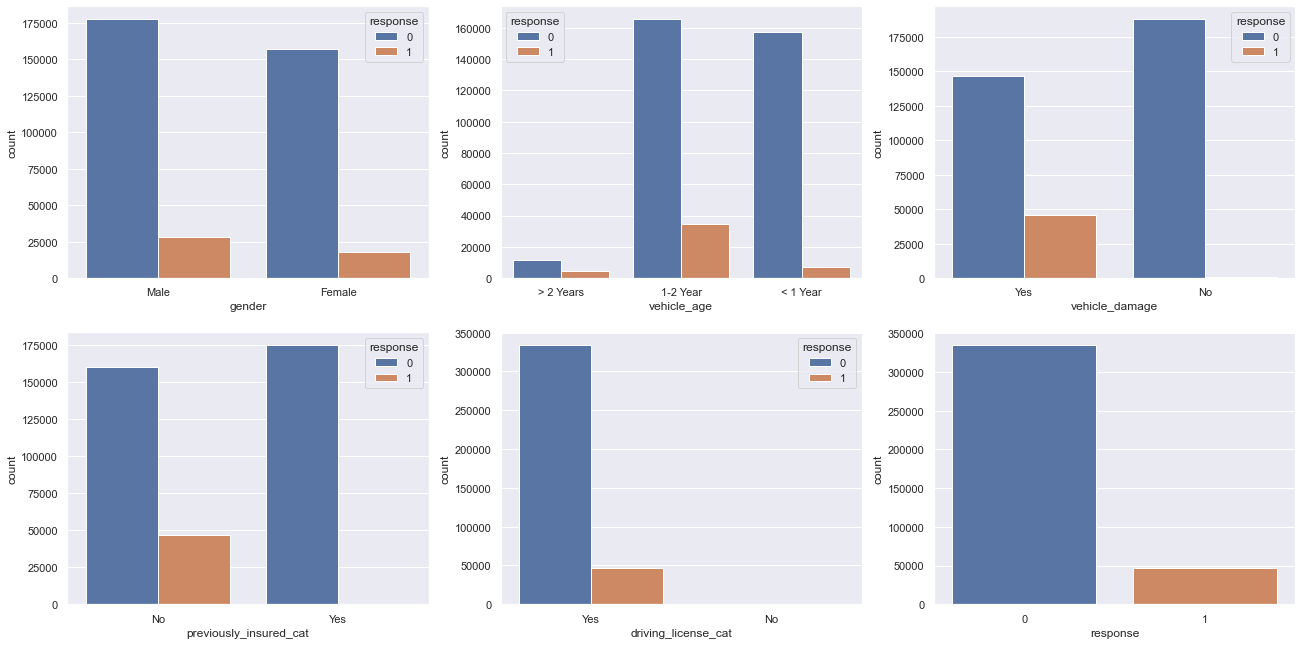

In [30]:
#gender
plt.subplot(2, 3, 1)
sns.countplot( df1['gender'], hue = df1['response']);

#vehicle_age
plt.subplot(2, 3, 2)
sns.countplot( df1['vehicle_age'], hue = df1['response']);

#vehicle_damage
plt.subplot(2, 3, 3)
sns.countplot( df1['vehicle_damage'], hue = df1['response']);

#previously_insured_cat
plt.subplot(2, 3, 4)
sns.countplot( df1['previously_insured_cat'], hue = df1['response']);

#driving_license_cat
plt.subplot(2, 3, 5)
sns.countplot( df1['driving_license_cat'], hue = df1['response']);

#response_cat
plt.subplot(2, 3, 6)
sns.countplot( df1['response']);

In [31]:
aux = df1[['id', 'annual_premium']].groupby('annual_premium').count().reset_index()
aux.sort_values(by = 'annual_premium', ascending = False).head(20)


,annual_premium,id
48837,540165.0,4
48836,508073.0,1
48835,495106.0,1
48834,489663.0,1
48833,472042.0,3
48832,448156.0,1
48831,402863.0,1
48830,402097.0,1
48829,399010.0,2
48828,366891.0,4


### 1.6.3 Initial insights:


- region_code and policy_sales_channel are nominal and multilevel categorical variables (53 and 155 levels). Plan encoding strategy;
- annual_premium has a high range, it's upper values are far higher than expected from mean and standard deviation (outliers?)
- vintage relates to the current year (insurance needs to be renewed every year, so it makes sense); 
- Unbalanced data - there is a lot more "No" than "Yes" on Response.

# 2.0 STEP 02 - FEATURE ENGINEERING

In [32]:
df2 = df1.copy()

In [33]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,driving_license_cat,previously_insured_cat,response_cat
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1,Yes,No,Yes
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0,Yes,No,No
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1,Yes,No,Yes
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0,Yes,Yes,No
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0,Yes,Yes,No


## 2.1 Hypotheses Mind Map

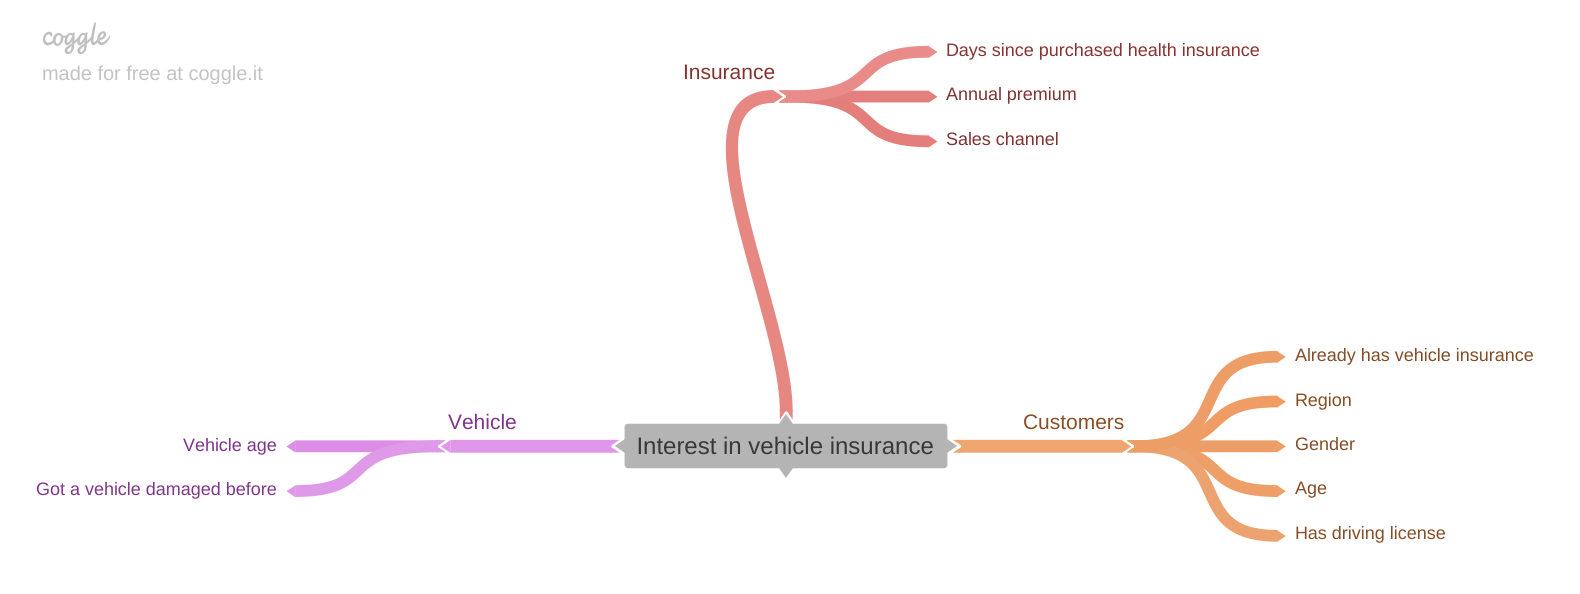

In [34]:
Image('image/Hypotheses mind map.png')

## 2.2 Hypothesis Creation

### 2.2.1 Customer Hypothesis

H1 - Customers from a certain region are more likely to be interested in purchasing auto insurance than customers from other regions. <br>
H2 - Male customers are more likely to be interested in purchasing auto insurance than female customers. <br>
H3 - Older customers are more likely to be interested in purchasing auto insurance. <br>
H4 - Customers that have a driving license are more likely to be interested in purchasing auto insurance. <br>
H5 - Customers that already have auto insurance are less likely to be interested in purchasing auto insurance. <br>

### 2.2.2 Vehicle Hypothesis

H6 - Customers that own their vehicles for over two years are less likely to be interested in purchasing auto insurance. <br>
H7 - Customers that that have already damage a vehicle before are more likely to be interested in purchasing auto insurance. <br> 

### 2.2.3 Insurance Hypothesis

H8 - Customers with a lower annual premium value are more likely to be interested in purchasing auto insurance. <br>
H9 - Customers that have been associated with the insurance company for a longer time are more likely to be interested in purchasing auto insurance. <br>
H10 - Customers outreached by a certain channel are more likely to be interested in purchasing auto insurance. <br>
H11 - Customers that live at regions where more car accidents happen are more likely to be interested in purchasing auto insurance. <br>

## 2.3 Final Hypothesis List

H1 - Customers from a certain region are more likely to be interested in purchasing auto insurance than customers from other regions. <br>
H2 - Male customers are more likely to be interested in purchasing auto insurance than female customers. <br>
H3 - Older customers are more likely to be interested in purchasing auto insurance. <br>
H4 - Customers that have a driving license are more likely to be interested in purchasing auto insurance. <br>
H5 - Customers that already have auto insurance are less likely to be interested in purchasing auto insurance. <br>
H6 - Customers that own their vehicles for over two years are less likely to be interested in purchasing auto insurance. <br>
H7 - Customers that that have already damaged a vehicle before are more likely to be interested in purchasing auto insurance. <br> 
H8 - Customers with a lower annual premium value are more likely to be interested in purchasing auto insurance. <br>
H9 - Customers that have been associated with the insurance company for a longer time are more likely to be interested in purchasing auto insurance. <br>
H10 - Customers outreached by a certain channel are more likely to be interested in purchasing auto insurance. <br>
H11 - Customers that live at regions where more car accidents happen are more likely to be interested in purchasing auto insurance. <br>

## 2.4 Feature Engineering

No features created.

# 3.0 STEP 03 - FEATURE FILTERING

In [35]:
df3 = df2.copy()

## 3.1 Row Selection

There are no null values, and it's not possible to be sure about outliers. Even though there are really high values in annual premium, the count is also high enough for these values for them not to be classified as outliers. All rows will be kept.

## 3.2 Column Selection

No columns dropped before EDA.

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [36]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Target Feature

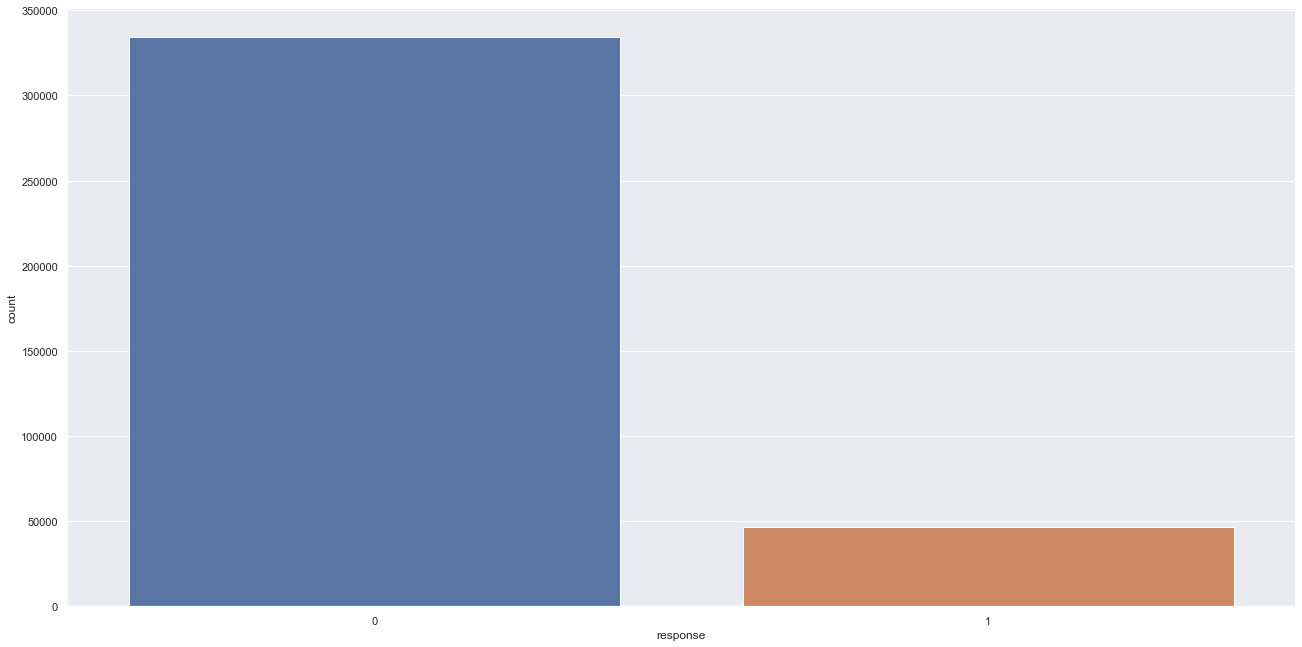

In [37]:
sns.countplot( df4['response'], );

### 4.1.2 Numerical Features

In [38]:
num_att = df4.select_dtypes(['int64','float64'])
cols_drop = ['driving_license', 'previously_insured', 'response']
num_att = num_att.drop(cols_drop, axis = 1)

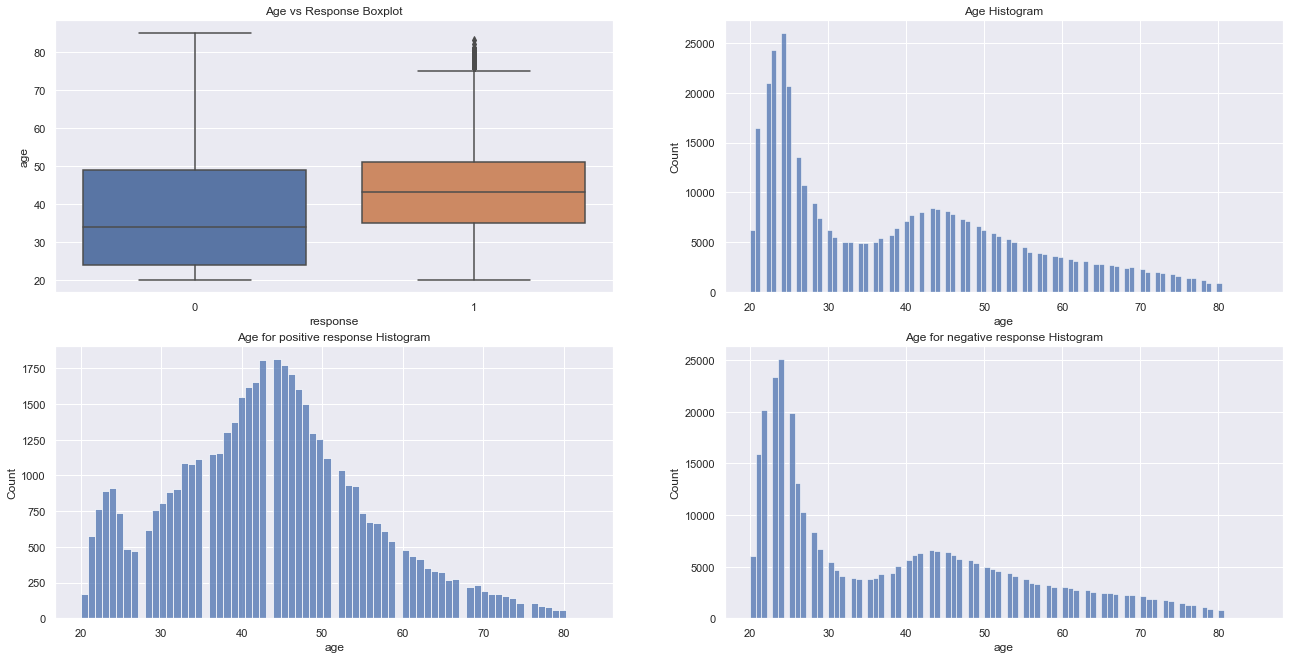

In [39]:
#age
plt.subplot(2, 2, 1)
sns.boxplot(x = 'response', y = 'age', data = df4);
plt.title('Age vs Response Boxplot');

plt.subplot(2, 2, 2)
sns.histplot(df4['age']);
plt.title('Age Histogram');

plt.subplot(2, 2, 3)
aux = df4[ df4['response'] == 1 ]
sns.histplot(aux['age']);
plt.title('Age for positive response Histogram');

plt.subplot(2, 2, 4)
aux = df4[ df4['response'] == 0 ]
sns.histplot(aux['age']);
plt.title('Age for negative response Histogram');

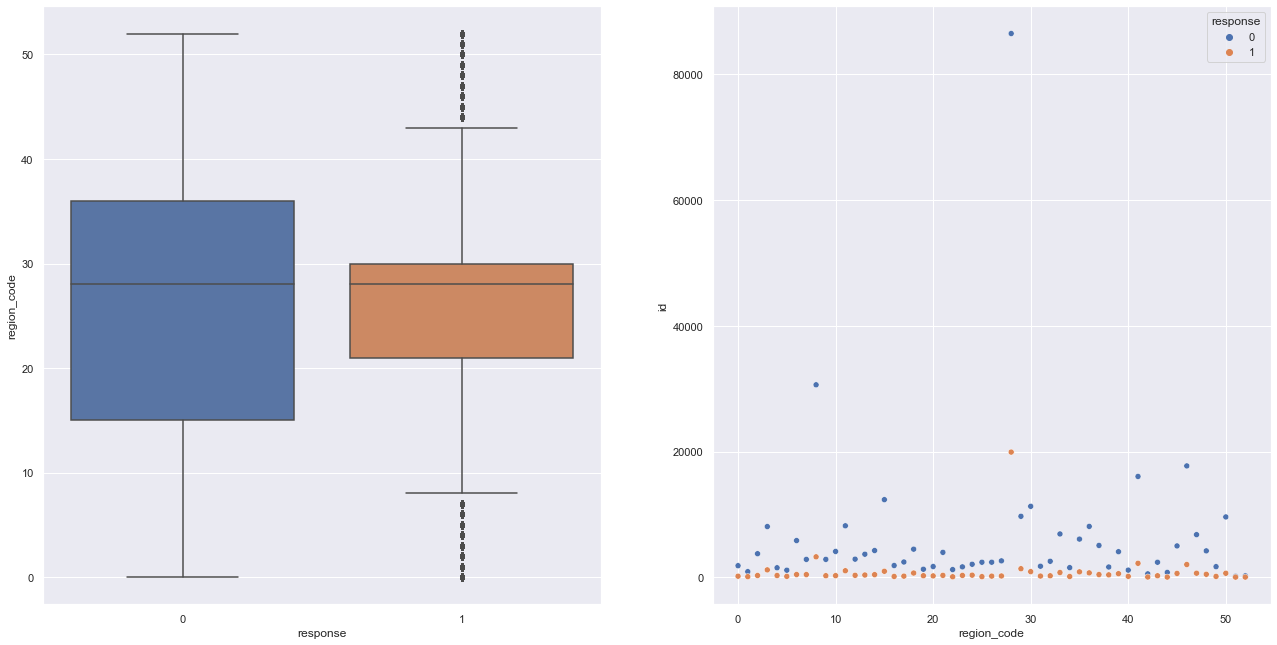

In [40]:
#region_code
plt.subplot(1, 2, 1)
sns.boxplot(x = 'response', y = 'region_code', data = df4);

plt.subplot(1, 2, 2)
aux = df4[['region_code', 'id', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x = 'region_code', y = 'id', hue = 'response', data = aux);

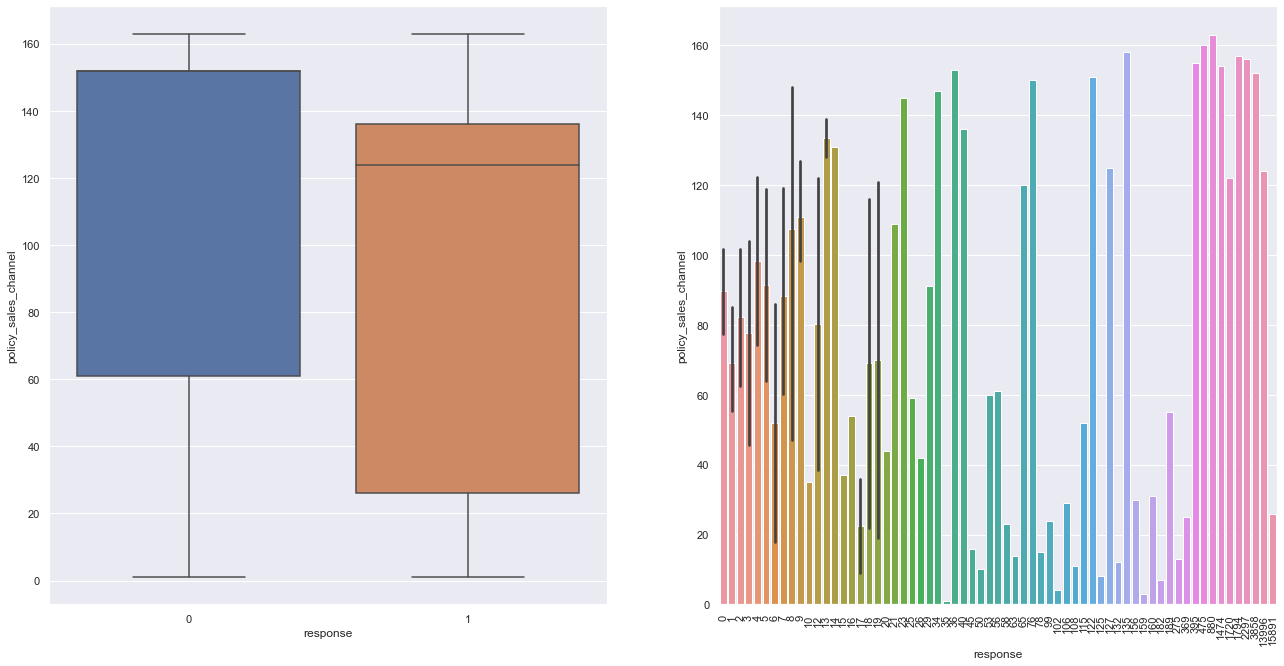

In [41]:
#policy_sales_channel
plt.subplot(1, 2, 1)
sns.boxplot(x = 'response', y = 'policy_sales_channel', data = df4);

plt.subplot(1, 2, 2)
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x = 'response', y = 'policy_sales_channel', data = aux);
plt.xticks(rotation = 90);

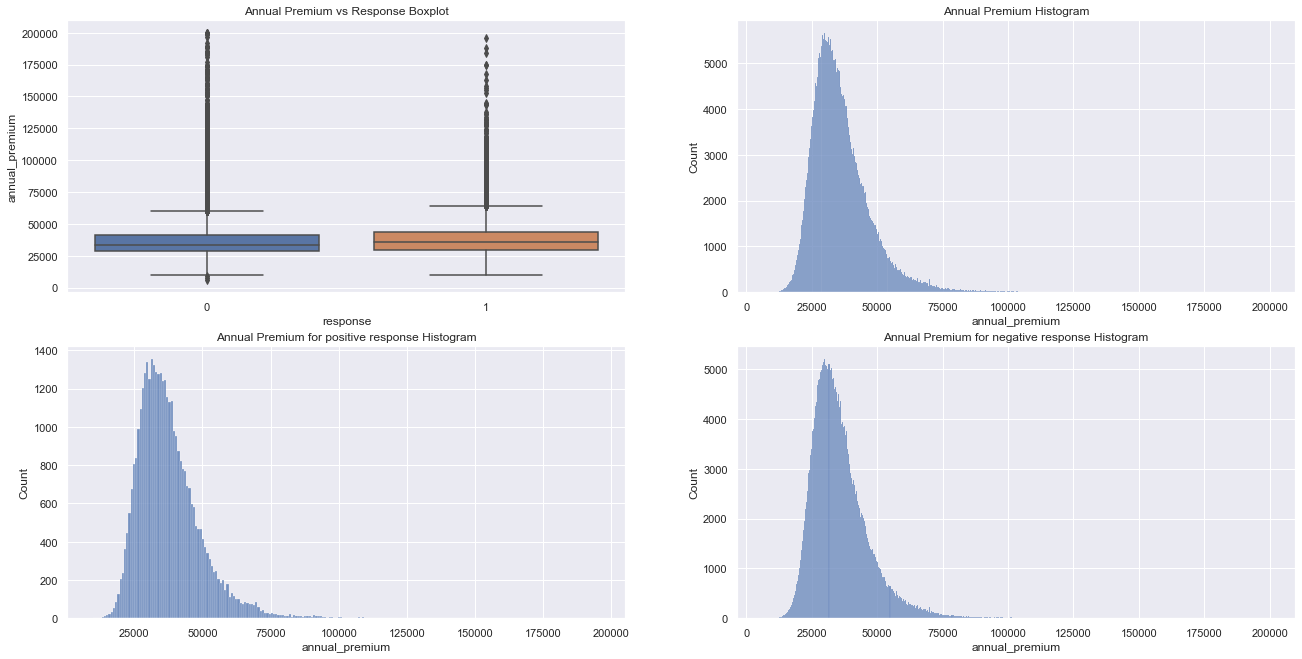

In [42]:
#annual_premium

aux = df4[ (df4['annual_premium'] < 200000) & (df4['annual_premium'] > 5000)]

plt.subplot(2, 2, 1)
sns.boxplot(x = 'response', y = 'annual_premium', data = aux);
plt.title('Annual Premium vs Response Boxplot');

plt.subplot(2, 2, 2)
sns.histplot(aux['annual_premium']);
plt.title('Annual Premium Histogram');

plt.subplot(2, 2, 3)
aux1 = aux[ aux['response'] == 1 ]
sns.histplot(aux1['annual_premium']);
plt.title('Annual Premium for positive response Histogram');

plt.subplot(2, 2, 4)
aux2 = aux[ aux['response'] == 0 ]
sns.histplot(aux2['annual_premium']);
plt.title('Annual Premium for negative response Histogram');

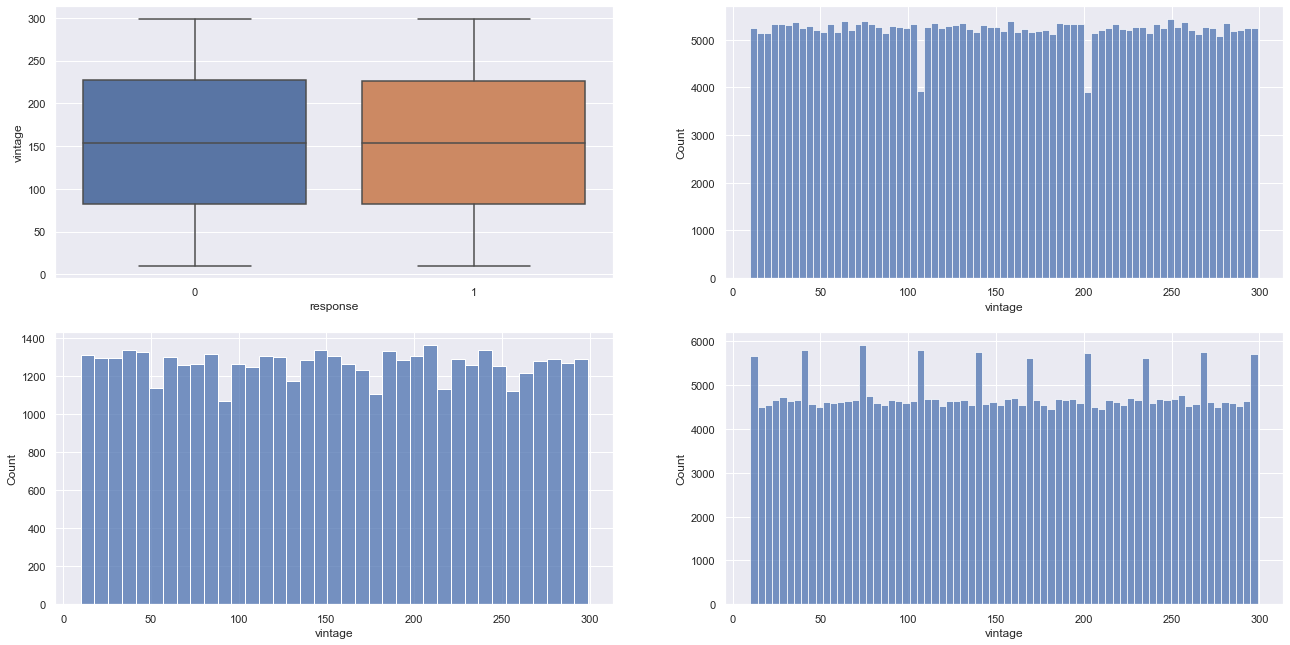

In [43]:
#vintage
plt.subplot(2, 2, 1)
sns.boxplot(x = 'response', y = 'vintage', data = df4);

plt.subplot(2, 2, 2)
sns.histplot(df4['vintage']);

plt.subplot(2, 2, 3)
aux = df4[ df4['response'] == 1 ]
sns.histplot(aux['vintage']);

plt.subplot(2, 2, 4)
aux = df4[ df4['response'] == 0 ]
sns.histplot(aux['vintage']);

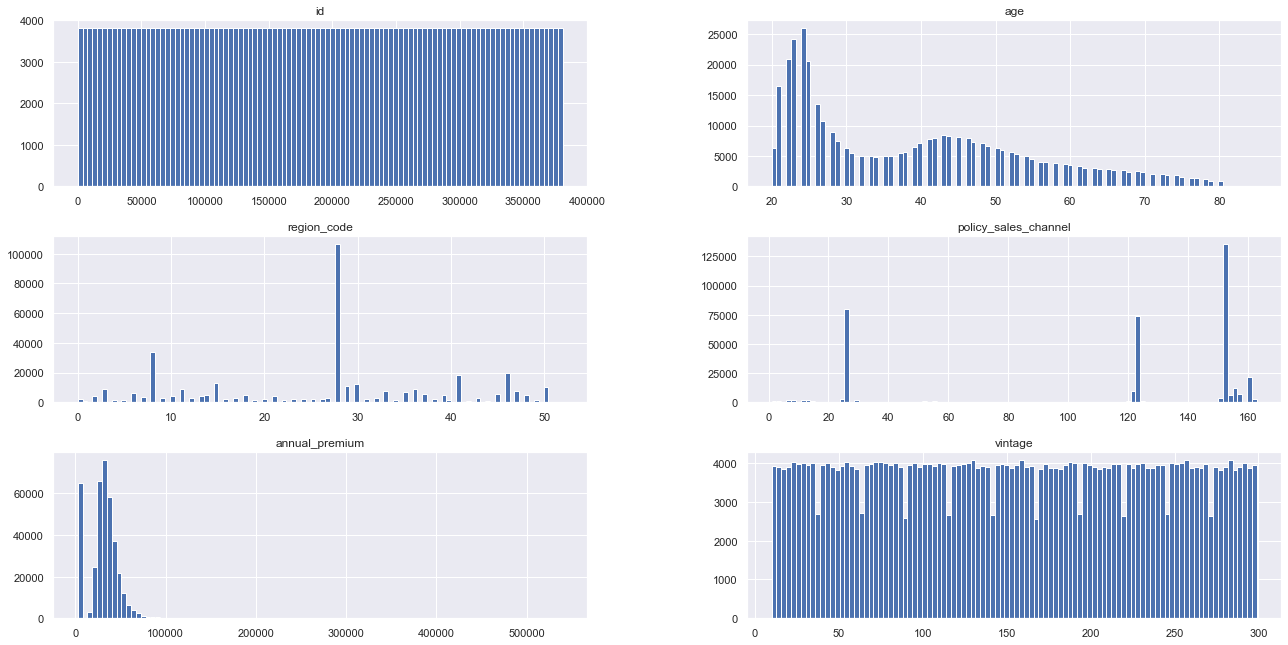

In [44]:
num_att.hist(bins = 100);

### 4.1.3 Categorical Features

In [45]:
cat_att = df4.select_dtypes('object')

In [46]:
#gender
aux = df4[['gender', 'id', 'response_cat']].groupby(['gender', 'response_cat']).count().reset_index()
aux['%'] = aux['id'].apply( lambda x: x/aux['id'].sum()*100 )
aux = aux.drop('id', axis = 1)
aux

,gender,response_cat,%
0,Female,No,41.152269
1,Female,Yes,4.771601
2,Male,No,46.591395
3,Male,Yes,7.484735


In [47]:
#vehicle_age
aux = df4[['vehicle_age', 'id', 'response_cat']].groupby(['vehicle_age', 'response_cat']).count().reset_index()
aux['%'] = aux['id'].apply( lambda x: x/aux['id'].sum()*100 )
aux = aux.drop('id', axis = 1)
aux

,vehicle_age,response_cat,%
0,1-2 Year,No,43.428520
1,1-2 Year,Yes,9.132820
2,< 1 Year,No,41.348800
3,< 1 Year,Yes,1.889748
4,> 2 Years,No,2.966343
5,> 2 Years,Yes,1.233768


In [48]:
#vehicle_damage
aux = df4[['vehicle_damage', 'id', 'response_cat']].groupby(['vehicle_damage', 'response_cat']).count().reset_index()
aux['%'] = aux['id'].apply( lambda x: x/aux['id'].sum()*100 )
aux = aux.drop('id', axis = 1)
aux

,vehicle_damage,response_cat,%
0,No,No,49.254675
1,No,Yes,0.257669
2,Yes,No,38.488989
3,Yes,Yes,11.998667


In [49]:
#driving_license_cat
aux = df4[['driving_license_cat', 'id', 'response_cat']].groupby(['driving_license_cat', 'response_cat']).count().reset_index()
aux['%'] = aux['id'].apply( lambda x: x/aux['id'].sum()*100 )
aux = aux.drop('id', axis = 1)
aux

,driving_license_cat,response_cat,%
0,No,No,0.202304
1,No,Yes,0.010758
2,Yes,No,87.541360
3,Yes,Yes,12.245578


In [50]:
#previously_insured_cat
aux = df4[['previously_insured_cat', 'id', 'response_cat']].groupby(['previously_insured_cat', 'response_cat']).count().reset_index()
aux['%'] = aux['id'].apply( lambda x: x/aux['id'].sum()*100 )
aux = aux.drop('id', axis = 1)
aux

,previously_insured_cat,response_cat,%
0,No,No,41.964110
1,No,Yes,12.214878
2,Yes,No,45.779554
3,Yes,Yes,0.041458


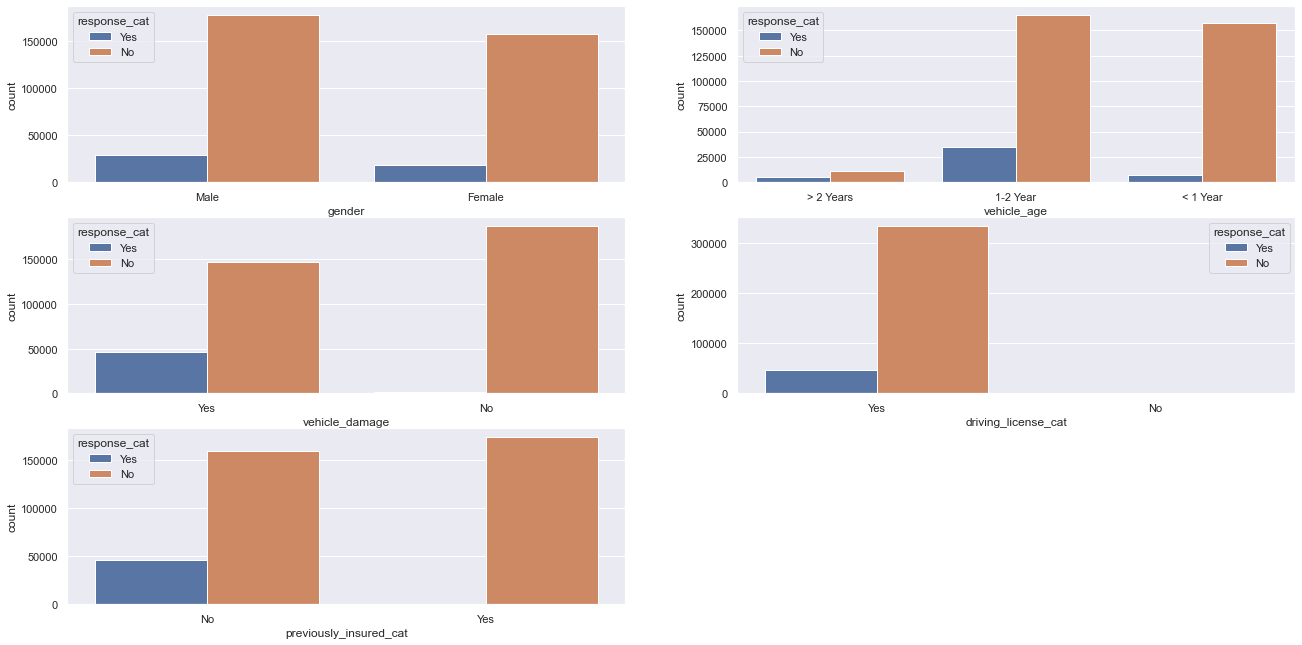

In [51]:
plt.subplot( 3, 2, 1 )
sns.countplot( x = 'gender', hue = 'response_cat', data = df4 );

plt.subplot( 3, 2, 2 )
sns.countplot( x = 'vehicle_age', hue = 'response_cat', data = df4 );

plt.subplot( 3, 2, 3 )
sns.countplot( x = 'vehicle_damage', hue = 'response_cat', data = df4 );

plt.subplot( 3, 2, 4 )
sns.countplot( x = 'driving_license_cat', hue = 'response_cat', data = df4 );

plt.subplot( 3, 2, 5 )
sns.countplot( x = 'previously_insured_cat', hue = 'response_cat', data = df4 );

## 4.2 Bivariate Analysis

### **H1.** Customers from a certain region are more likely to be interested in purchasing auto insurance than customers from other regions.
**True** - Customers from region 28 are more interested in auto insurance. Why? There is a high number of car accidents in that region!

<AxesSubplot:xlabel='region_code', ylabel='count'>

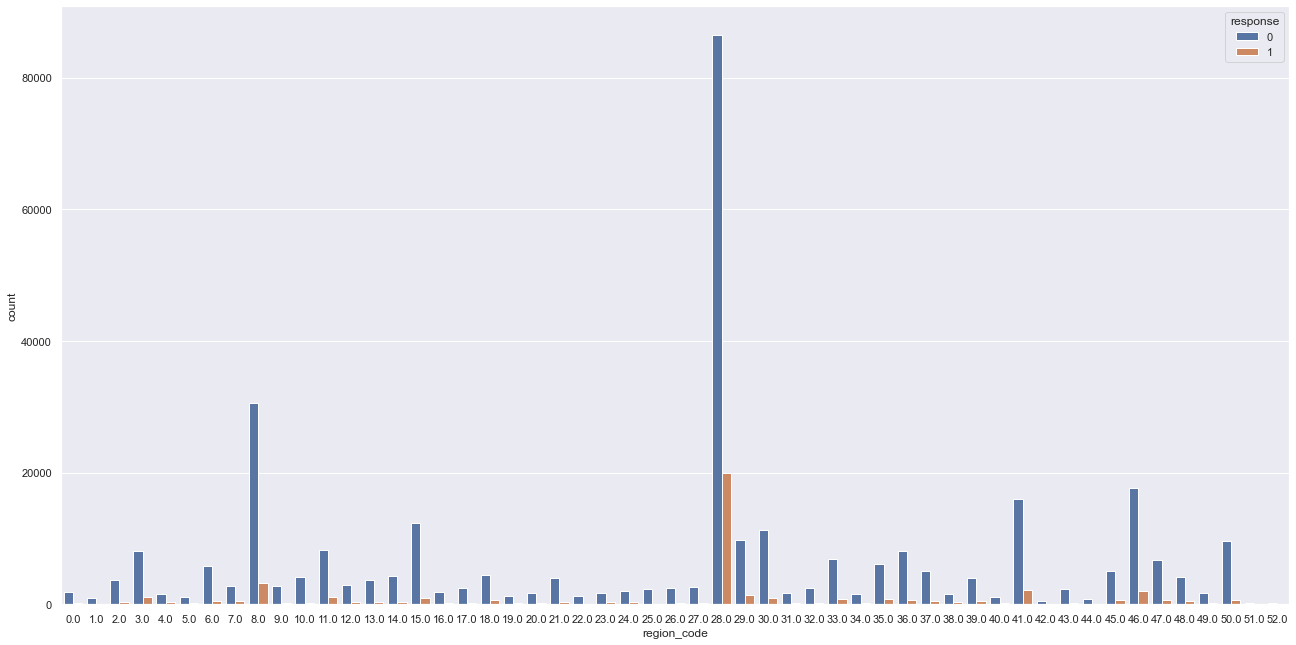

In [52]:
aux = df4[ ['id', 'region_code', 'response'] ].groupby(['region_code', 'response']).count().reset_index()
sns.countplot('region_code', hue = 'response', data = df4)

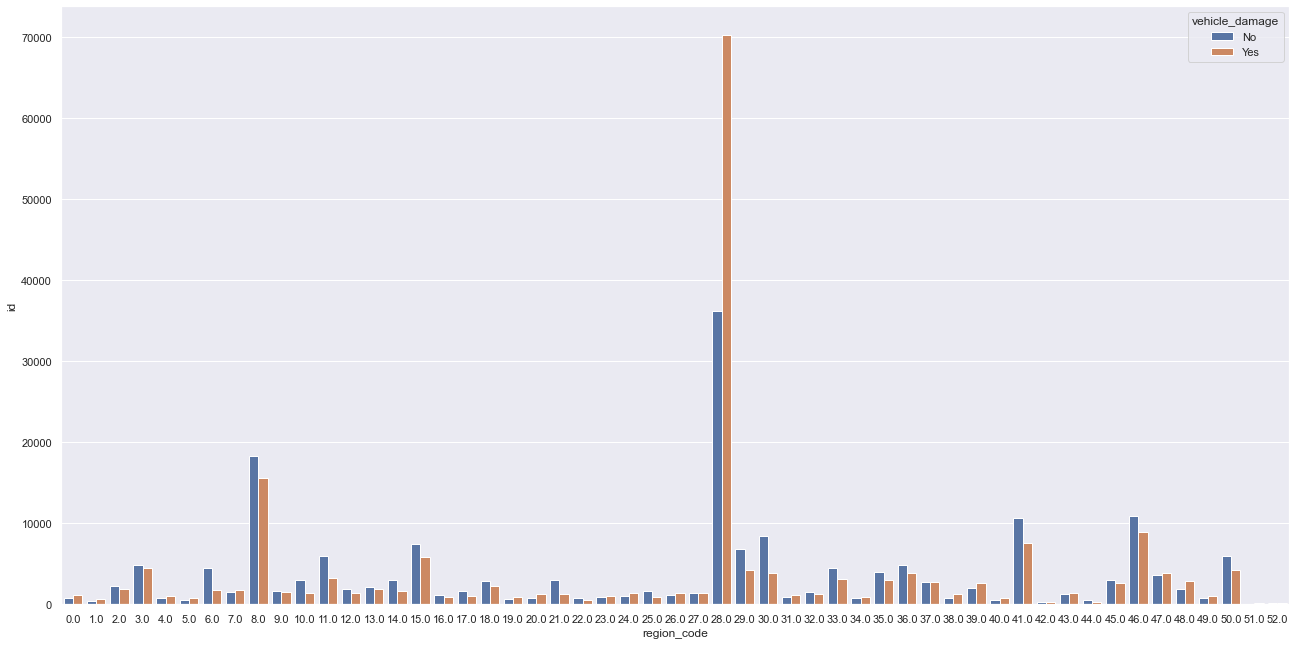

In [53]:
aux1 = df4[ ['id', 'region_code', 'vehicle_damage'] ].groupby(['region_code', 'vehicle_damage']).count().reset_index()
sns.barplot( x = 'region_code', y = 'id', hue = 'vehicle_damage', data = aux1);

In [54]:
aux2 = df4[ ( df4['region_code'] == 28.0 ) & ( df4['vehicle_damage'] == 'Yes' ) ]

aux2.count()

id                        70236
gender                    70236
age                       70236
region_code               70236
policy_sales_channel      70236
driving_license           70236
vehicle_age               70236
vehicle_damage            70236
previously_insured        70236
annual_premium            70236
vintage                   70236
response                  70236
driving_license_cat       70236
previously_insured_cat    70236
response_cat              70236
dtype: int64

### **H2.** Male customers are more likely to be interested in purchasing auto insurance than female customers.
**True** - Male customers are indeed more interested in purchasing auto insurance than female customers.

In [55]:
aux1 = df4[ ['id', 'gender', 'response'] ].groupby(['gender', 'response']).count().reset_index()
aux1['percentage'] = aux1['id']/len(df4)*100
aux1


,gender,response,id,percentage
0,Female,0,156835,41.152269
1,Female,1,18185,4.771601
2,Male,0,177564,46.591395
3,Male,1,28525,7.484735


### **H3.** Older customers are more likely to be interested in purchasing auto insurance.
**False** - Interest raises as age raises until a determined age, than it begins falling down again.

<AxesSubplot:xlabel='age', ylabel='Count'>

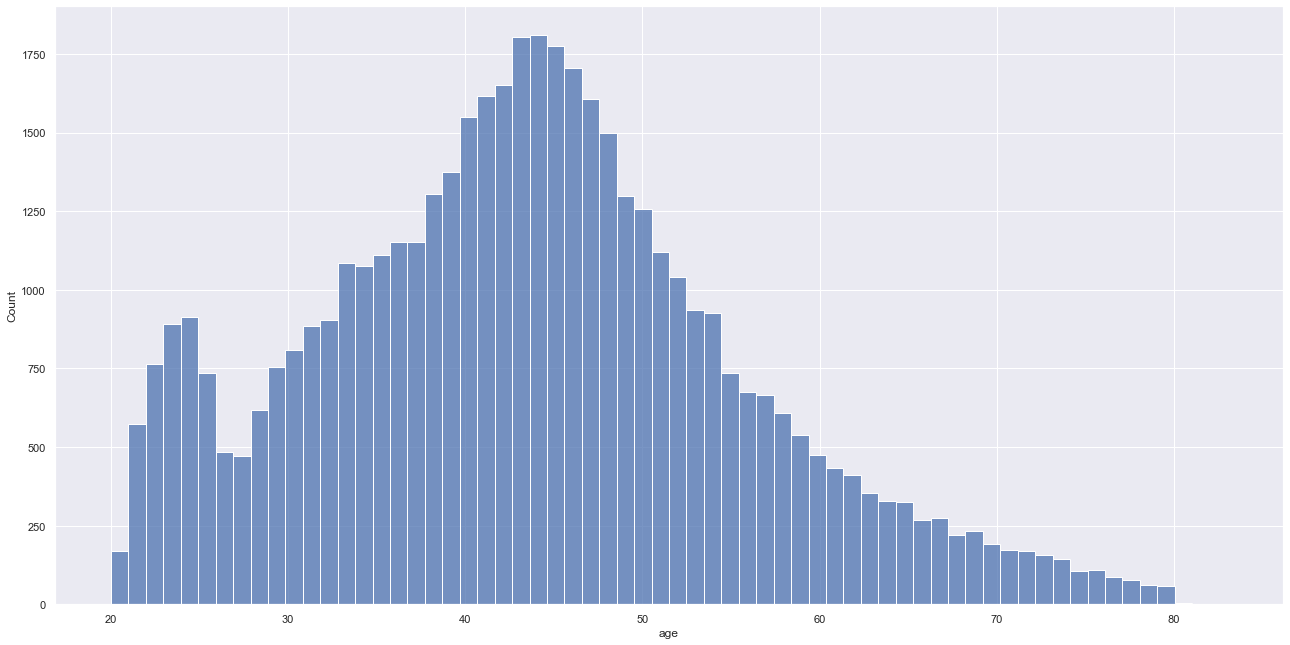

In [56]:
aux1 = df4[ df4['response'] == 1 ]
sns.histplot( aux1['age'], bins = 64 )

### **H4.** Customers that have a driving license are more likely to be interested in purchasing auto insurance.
**True** - All of the interested customers have driving license.

<AxesSubplot:xlabel='driving_license_cat', ylabel='count'>

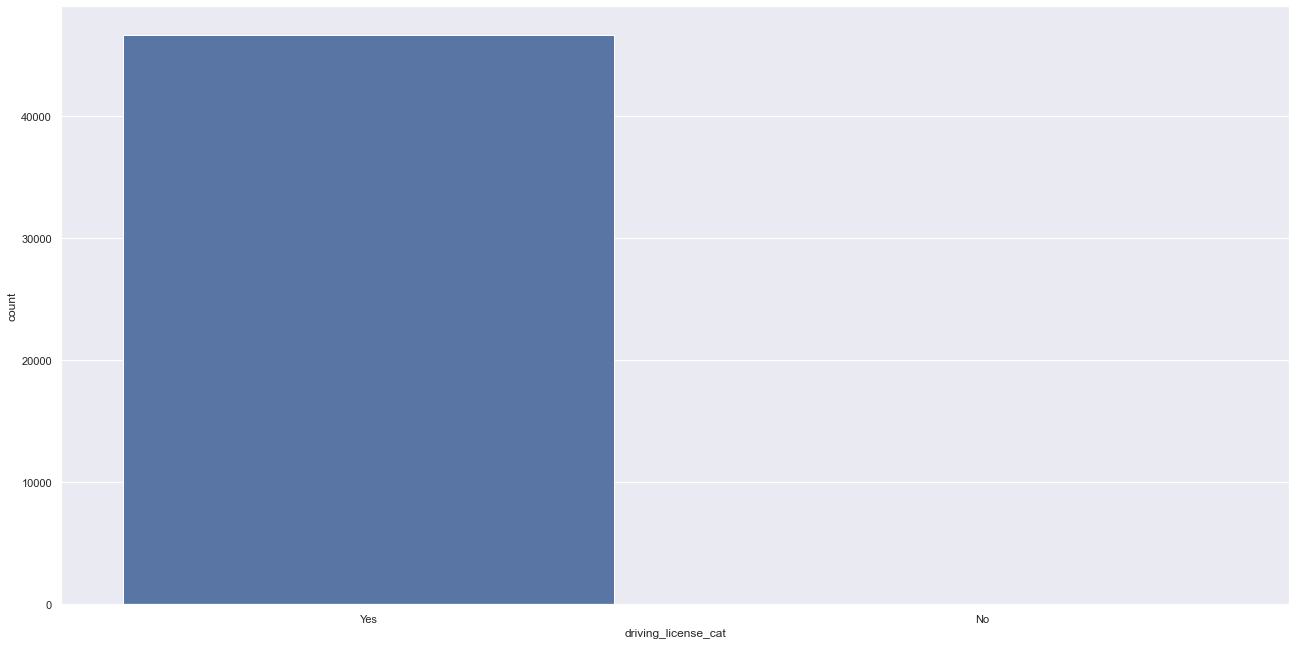

In [57]:
sns.countplot( aux1['driving_license_cat'])

### **H5.** Customers that already have auto insurance are less likely to be interested in purchasing auto insurance.
**True** - Any of the interested customers has a drivers license.

46710

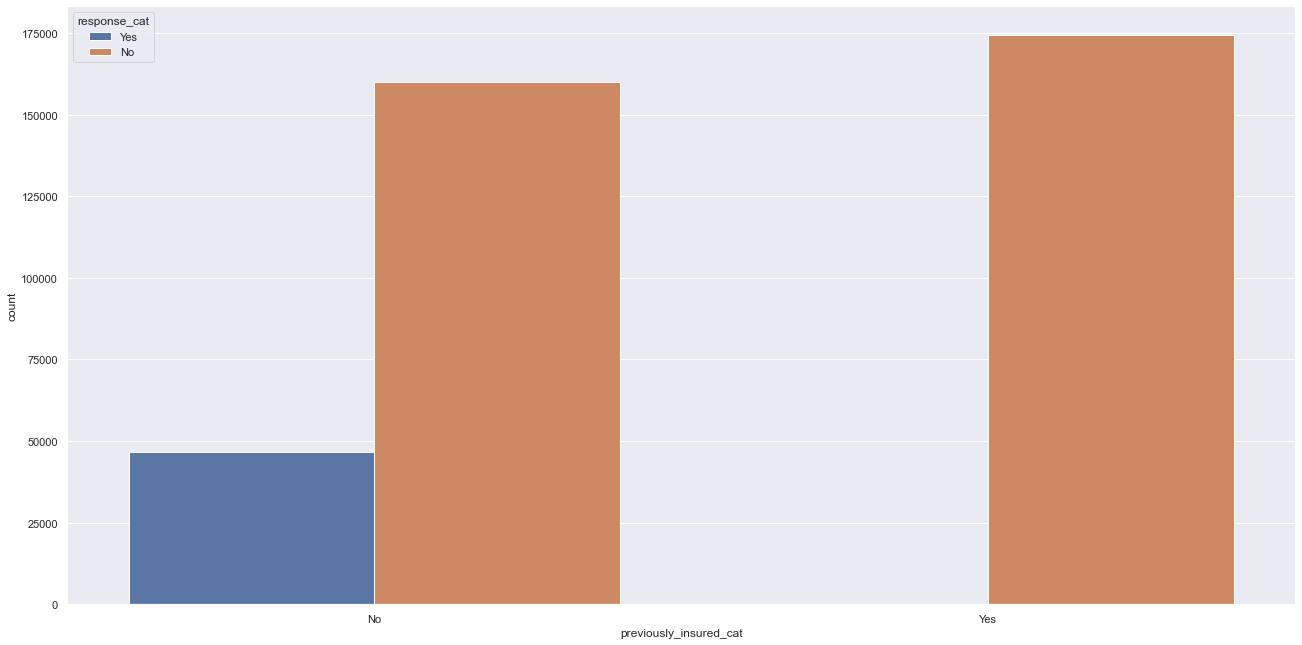

In [58]:
sns.countplot( x = 'previously_insured_cat', hue = 'response_cat', data = df4)

aux1['previously_insured_cat'].count()

### **H6.** Customers that own their vehicles for over two years are less likely to be interested in purchasing auto insurance.
**False** - Customers that own their vehicles for 1 or 2 years are the most interested in purchasing auto insurance.

<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

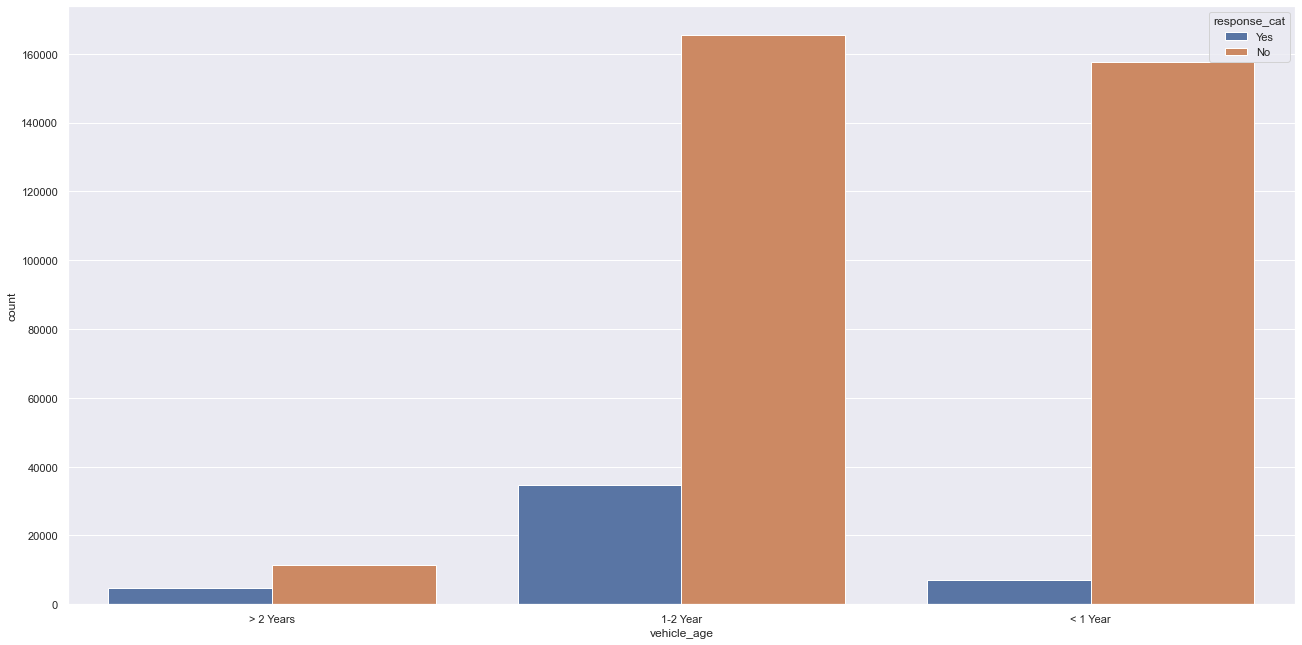

In [59]:
sns.countplot( x = 'vehicle_age', hue = 'response_cat', data = df4)

### **H7.** Customers that that have already damaged a vehicle before are more likely to be interested in purchasing auto insurance.
**True** - Most of the interested costumers has already damaged a vehicle before.

<AxesSubplot:xlabel='vehicle_damage', ylabel='count'>

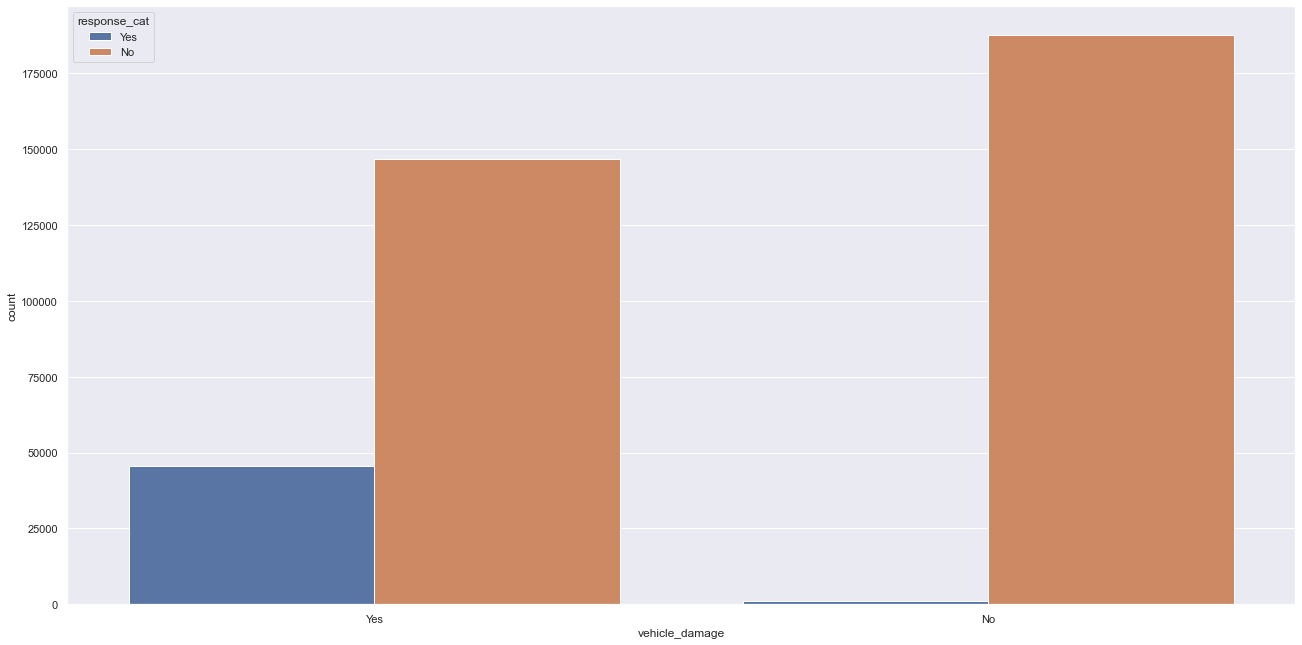

In [60]:
sns.countplot( x = 'vehicle_damage', hue = 'response_cat', data = df4)

### **H8.** Customers with a lower annual premium value are more likely to be interested in purchasing auto insurance. 
**False** - Annual premium and interest are not proportional.

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

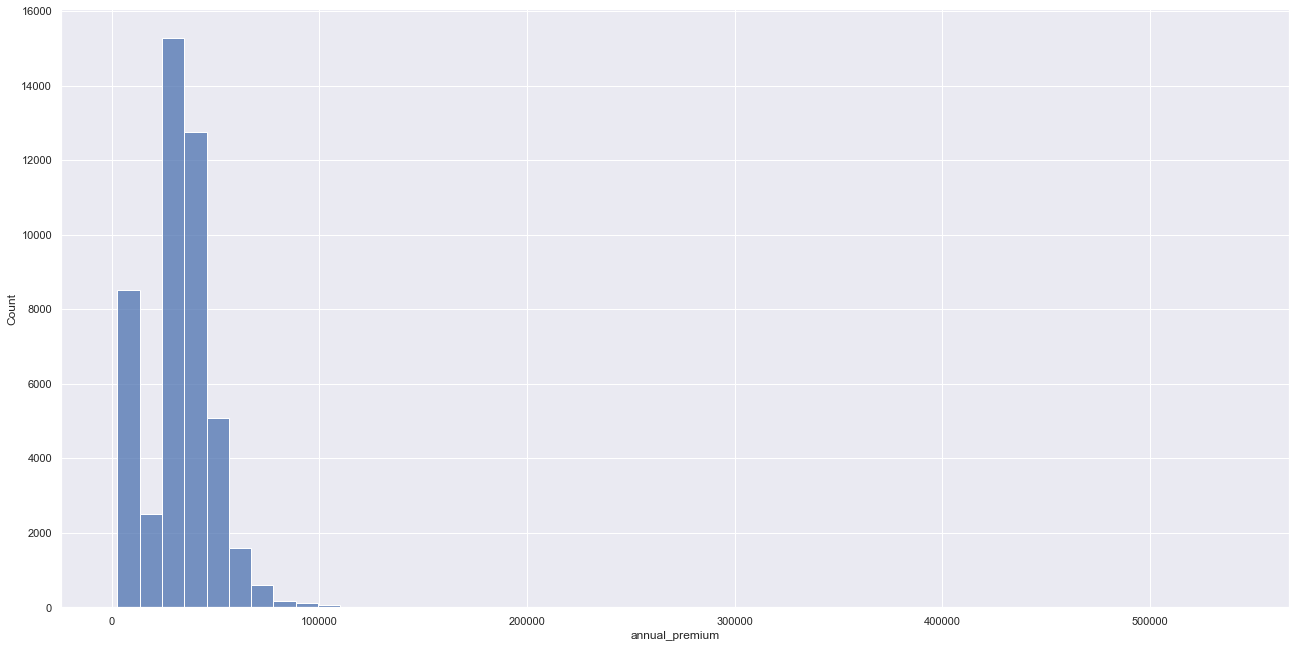

In [61]:
aux1 = df4[ df4['response'] == 1 ]
sns.histplot( aux1['annual_premium'], bins = 50 )

### **H9.** Customers that have been associated with the insurance company for a longer time are more likely to be interested in purchasing auto insurance.
**False** - The distribution of interested customers is balanced over time.

<AxesSubplot:xlabel='vintage', ylabel='Count'>

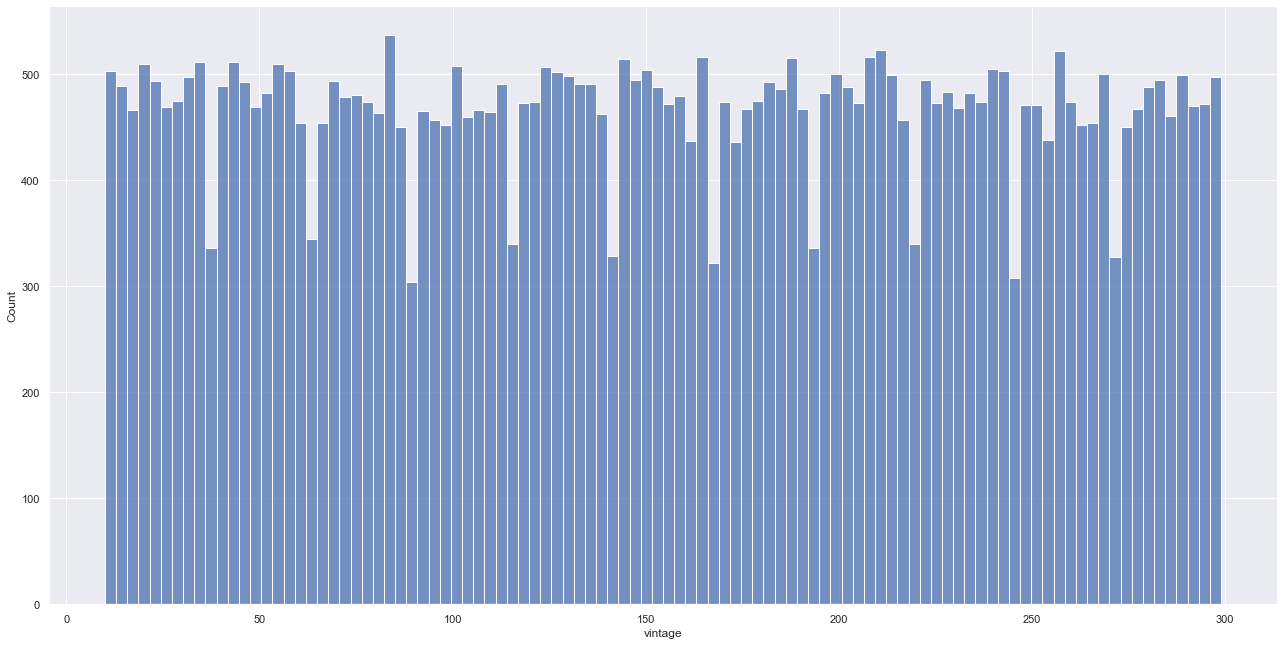

In [62]:
aux1 = df4[ df4['response'] == 1 ]
sns.histplot( aux1['vintage'], bins = 100 )

### H10. Customers outreached by a certain channel are more likely to be interested in purchasing auto insurance.
**False** - There are some channels with higher rates, but any of them seems more successfull than the others.

In [63]:
aux1 = df4[ ['id', 'policy_sales_channel', 'response'] ].groupby(['policy_sales_channel', 'response']).count().reset_index()
aux1['percentage'] = aux1['id']

for i in range( len( aux1 ) ):
    if aux1['response'][i] == 0:
        aux1['percentage'][i] = aux1['id'][i]/( aux1['id'][i] + aux1['id'][i+1] )*100
    else:
        aux1['percentage'][i] = aux1['id'][i]/( aux1['id'][i] + aux1['id'][i-1] )*100

aux1[ aux1['response'] == 1 ].sort_values(by = 'percentage', ascending = False)

,policy_sales_channel,response,id,percentage
52,28.0,1,1,33
50,27.0,1,1,33
261,155.0,1,395,32
66,36.0,1,17,32
273,163.0,1,880,30
5,3.0,1,159,30
205,121.0,1,19,29
138,80.0,1,4,28
172,101.0,1,2,28
147,87.0,1,2,28


### **H11.** Customers that live at regions where more car accidents happen are more likely to be interested in purchasing auto insurance.
**True** - As showed on H1.

### 4.2.1 Bivariate analysis overview

In [64]:
tab = [ [ 'Hypothesis', 'Status', 'Importance'],
      ['H1', 'True', 'Medium'],
      ['H2', 'True', 'Medium'],
      ['H3', 'False', 'Medium'],
      ['H4', 'True', 'Low'],
      ['H5', 'True', 'Medium'],
      ['H6', 'False', 'High'],
      ['H7', 'True', 'High'],
      ['H8', 'False', 'Medium'],
      ['H9', 'False', 'Low'],
      ['H10', 'False', 'Low'],
      ['H11', 'True', 'Medium'], 
            ]

print ( tabulate( tab , headers = 'firstrow') )

Hypothesis    Status    Importance
------------  --------  ------------
H1            True      Medium
H2            True      Medium
H3            False     Medium
H4            True      Low
H5            True      Medium
H6            False     High
H7            True      High
H8            False     Medium
H9            False     Low
H10           False     Low
H11           True      Medium


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Features

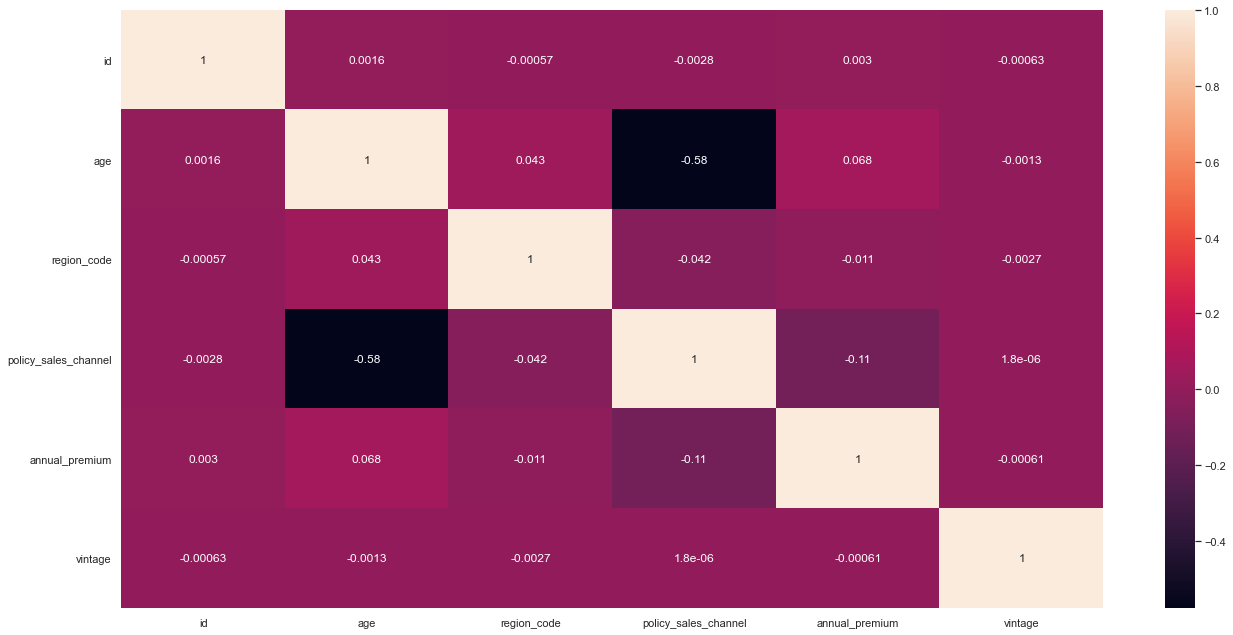

In [65]:
sns.heatmap( num_att.corr( method = 'pearson') , annot = True );

### 4.3.2 Categorical Features

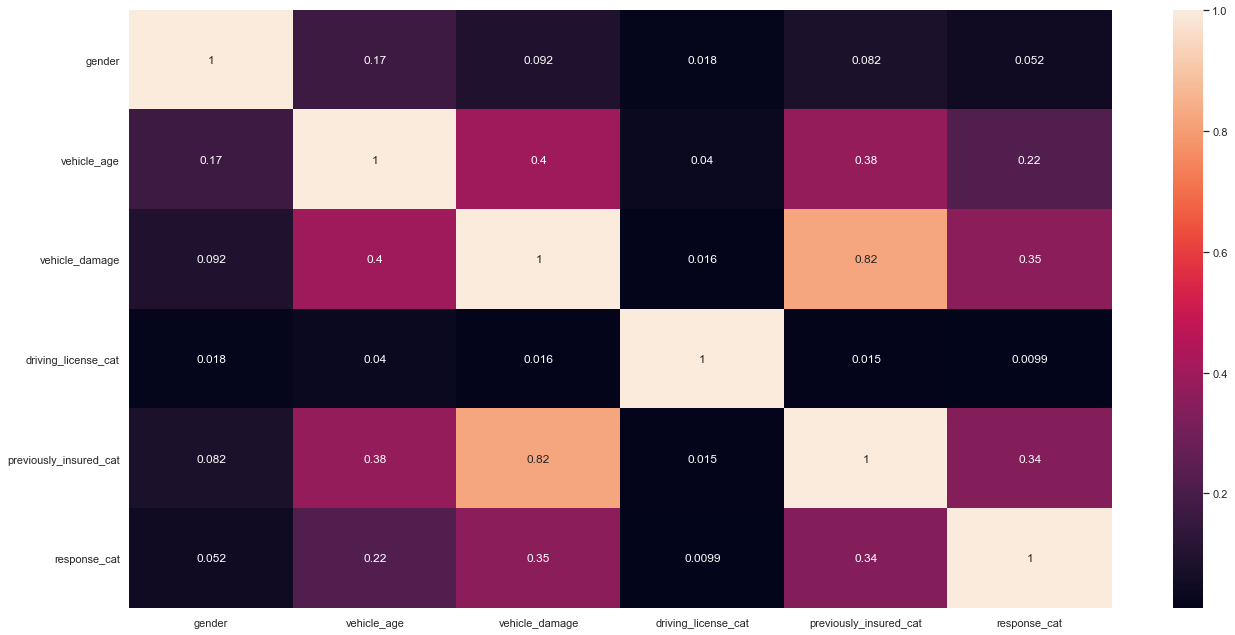

In [66]:
cat_corr = cramers_v(cat_att)

In [67]:
cols_drop = ['previously_insured_cat', 'driving_license_cat', 'response_cat']
df4 = df4.drop(cols_drop, axis = 1)

# 5.0 STEP 05 - DATA PREPARATION

In [68]:
df5 = df4.copy()

## 5.0.1 Train and validation data split

In [69]:
X = df5.drop(['response', 'id'], axis = 1)
y = df5['response']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

df5 = pd.concat( [X_train, y_train], axis = 1)

## 5.1 Standardization

In [70]:
#annual_premium
ss = pp.StandardScaler()

df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( 'parameters/annual_premium_scaler.pkl', 'wb' ) )

## 5.2 Rescaling

In [71]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

In [72]:
#age
df5['age'] = mms_vintage.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( 'parameters/age_scaler.pkl', 'wb' ) )

#vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( 'parameters/vintage_scaler.pkl', 'wb' ) )

## 5.3 Transfomation

In [73]:
#region_code - frequency encoding
fe_region_code = df5.groupby('region_code').size()/len( df5 )
df5.loc[:, 'region_code'] = df5['region_code'].map( fe_region_code)
pickle.dump( fe_region_code, open( 'parameters/fe_region_code.pkl', 'wb' ) )

#policy_sales_channel - frequency encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( 'parameters/fe_policy_sales_channel.pkl', 'wb' ) )

#vehicle_age
df5 = pd.get_dummies( df5, prefix = ['vehicle_age'], columns = ['vehicle_age'] )

In [74]:
#gender
df5['gender'] = df5['gender'].apply( lambda x: 1 if x == 'Male' else 0)

#vehicle_damage
df5['vehicle_damage'] = df5['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)


In [75]:
df5.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
332803,0,0.292308,0.034833,0.003309,1,1,0,1.294417,0.750865,1,1,0,0
116248,1,0.276923,0.024107,0.209638,1,1,0,-0.436638,0.065744,0,1,0,0
255005,1,0.030769,0.032091,0.353472,1,0,1,0.854640,0.539792,0,0,1,0
317474,0,0.046154,0.047913,0.010050,1,0,1,-0.083449,0.923875,0,0,1,0
344212,1,0.553846,0.012408,0.015901,1,1,0,-1.619422,0.501730,0,0,0,1


## 5.4 Validation Data Preparation

In [76]:
#annual_premium
ss = pp.StandardScaler()

X_val['annual_premium'] = ss.fit_transform( X_val[['annual_premium']].values )

#age
X_val['age'] = mms_vintage.fit_transform( X_val[['age']].values )

#vintage
X_val['vintage'] = mms_vintage.fit_transform( X_val[['vintage']].values )

#region_code - frequency encoding
X_val.loc[:, 'region_code'] = X_val['region_code'].map( fe_region_code)

#policy_sales_channel - frequency encoding
X_val.loc[:, 'policy_sales_channel'] = X_val['policy_sales_channel'].map( fe_policy_sales_channel)

#vehicle_age
X_val = pd.get_dummies( X_val, prefix = ['vehicle_age'], columns = ['vehicle_age'] )

#gender
X_val['gender'] = X_val['gender'].apply( lambda x: 1 if x == 'Male' else 0)

#vehicle_damage
X_val['vehicle_damage'] = X_val['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

#fill NAs
X_val = X_val.fillna(0);

# 6.0 STEP 06 - FEATURE SELECTION

In [77]:
df6 = df5.copy()

In [78]:
df6.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
332803,0,0.292308,0.034833,0.003309,1,1,0,1.294417,0.750865,1,1,0,0
116248,1,0.276923,0.024107,0.209638,1,1,0,-0.436638,0.065744,0,1,0,0
255005,1,0.030769,0.032091,0.353472,1,0,1,0.854640,0.539792,0,0,1,0
317474,0,0.046154,0.047913,0.010050,1,0,1,-0.083449,0.923875,0,0,1,0
344212,1,0.553846,0.012408,0.015901,1,1,0,-1.619422,0.501730,0,0,0,1


## 6.2 Applying Boruta

In [79]:
X_train_n = df6.drop('response', axis = 1).values
y_train_n = y_train.values

In [80]:
#commenting Boruta so it won't run next time we open this notebook
#rf = en.RandomForestRegressor( n_jobs = 1)

#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train_n, y_train_n)

In [81]:
#cols_selected = boruta.support_.tolist()



#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#cols_not_selected_boruta = np.setdiff1d( X_train_fs.columns, cols_selected_boruta )



In [82]:
cols_selected_boruta = ['vehicle_damage']

## 6.3 Features Importance

In [83]:
#model definition

#forest = en.ExtraTreesClassifier( n_estimators = 250, random_state = 0, n_jobs = 1)

#data preparation

#X_train_n = df5.drop('response', axis = 1)
#y_train_n = y_train.values
#forest.fit(X_train_n, y_train_n)

In [84]:
#importances = forest.feature_importances_
#print( ' Ranking de features:' )
#df = pd.DataFrame()
#for i, j in zip( X_train_n, importances ):
#    aux = pd.DataFrame( {'feature': i, 'importance': j} , index = [0] )
#   df = pd.concat([df, aux], axis = 0)
#print( df.sort_values( 'importance', ascending = False ) )

#indices = np.argsort(importances)[::-1]
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)

#plt.figure()
#plt.title('Importância das features')
#plt.bar(range(X_train_n.shape[1]), importances[indices], yerr = std[indices])
#plt.xticks(range(X_train_n.shape[1]), indices)
#plt.xlim([-1, X_train_n.shape[1]])
#plt.show()

In [85]:
cols_selected_importance = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

# 7.0 STEP 07 - MACHINE LEARNING MODELS

- 6 machine learning models will be trained and tested. If any of them behaves clearly worse than the others, it will be discarded;
- Since the questions request percentage of interested customers, the main metric to notice here is RECALL;
- The remaining models will then be evaluated through 5-fold cross validation, and the best performing ones will proceed to fine tuning.

In [86]:
df7 = df6.copy()

In [87]:
x_training = df7[cols_selected_importance]
x_training['response'] = df7['response']
x_training.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured,response
332803,0.750865,1.294417,0.292308,0.034833,1,0.003309,0,1
116248,0.065744,-0.436638,0.276923,0.024107,1,0.209638,0,0
255005,0.539792,0.854640,0.030769,0.032091,0,0.353472,1,0
317474,0.923875,-0.083449,0.046154,0.047913,0,0.010050,1,0
344212,0.501730,-1.619422,0.553846,0.012408,1,0.015901,0,0


In [88]:
X_train_m = x_training[cols_selected_importance]
X_val_m = X_val[cols_selected_importance]

## 7.1 KNN

In [89]:
#model definition
knn_model = nh.KNeighborsClassifier( n_neighbors = 7 )

#model training
knn_model.fit(X_train_m, y_train)

#model prediction
yhat_knn = knn_model.predict_proba(X_val_m)

#performance
k_prop_ml = round( 20000*len(y_val)/test_sample_size )
perf_knn = metrics_top_k(yhat_knn, y_val)
perf_knn.iloc[k_prop_ml -1]

index        159455.000000
response          1.000000
score             0.285714
ranking       12000.000000
precision         0.312833
recall            0.394204
Name: 11999, dtype: float64

## 7.2 Logistic Regression

In [90]:
# model definition
logreg_model = lm.LogisticRegression()

#model_training
logreg_model.fit( X_train_m, y_train )

# model prediction
yhat_logreg = logreg_model.predict_proba( X_val_m )

#performance
k_prop_ml = round( 20000*len(y_val)/test_sample_size )
perf_logreg = metrics_top_k(yhat_logreg, y_val)
perf_logreg.iloc[k_prop_ml -1]

index        321536.000000
response          0.000000
score             0.274044
ranking       12000.000000
precision         0.309250
recall            0.389688
Name: 11999, dtype: float64

## 7.3 Random Forest

In [91]:
# model definition
rf_model = en.RandomForestClassifier( n_estimators = 100, random_state = 42 )

#model_training
rf_model.fit( X_train_m, y_train )

# model prediction
yhat_rf = rf_model.predict_proba( X_val_m )

#performance
k_prop_ml = round( 20000*len(y_val)/test_sample_size )
perf_rf = metrics_top_k(yhat_rf, y_val)
perf_rf.iloc[k_prop_ml -1]

index        64559.000000
response         0.000000
score            0.320000
ranking      12000.000000
precision        0.344583
recall           0.434212
Name: 11999, dtype: float64

## 7.4 XGBOOST

In [92]:
xgb_model = xgb.XGBClassifier( objective = 'reg:squarederror' , n_estimators = 100) 
                            

#model training
xgb_model.fit( X_train_m, y_train )

# model prediction 
yhat_xgb = xgb_model.predict_proba( X_val_m )

#performance
k_prop_ml = round( 20000*len(y_val)/test_sample_size )
perf_xgb = metrics_top_k(yhat_xgb, y_val)
perf_xgb.iloc[k_prop_ml -1]

index        114224.000000
response          0.000000
score             0.310754
ranking       12000.000000
precision         0.374750
recall            0.472225
Name: 11999, dtype: float64

## 7.5 ExtraTrees

In [93]:
# model definition
#et_model = en.ExtraTreesClassifier( )
et_model = en.ExtraTreesClassifier( n_estimators = 100, n_jobs = -1, random_state = 42 )

#model_training
et_model.fit( X_train_m, y_train )

# model prediction
yhat_et = et_model.predict_proba( X_val_m )

#performance
k_prop_ml = round( 20000*len(y_val)/test_sample_size )
perf_et = metrics_top_k(yhat_et, y_val)
perf_et.iloc[k_prop_ml -1]


index        314715.000000
response          1.000000
score             0.310000
ranking       12000.000000
precision         0.336417
recall            0.423921
Name: 11999, dtype: float64

## 7.6 Gaussian Naive Bayes

In [94]:
# model definition
nb_model = nb.GaussianNB()

#model_training
nb_model.fit( X_train_m, y_train )

# model prediction
yhat_nb = nb_model.predict_proba( X_val_m )

#performance
k_prop_ml = round( 20000*len(y_val)/test_sample_size )
perf_nb = metrics_top_k(yhat_nb, y_val)
perf_nb.iloc[k_prop_ml -1]


index        181765.000000
response          0.000000
score             0.959912
ranking       12000.000000
precision         0.310250
recall            0.390948
Name: 11999, dtype: float64

## 7.7 Model Comparison

### 7.7.1 - Gain Curves Comparison

In [95]:
k = 20000

metrics_knn = metrics_top_k(yhat_knn, y_val)
metrics_logreg = metrics_top_k(yhat_logreg, y_val)
metrics_rf = metrics_top_k(yhat_rf, y_val)
metrics_xgb = metrics_top_k(yhat_xgb, y_val)
metrics_et = metrics_top_k(yhat_et, y_val)
metrics_nb = metrics_top_k(yhat_nb, y_val)

precision = {'knn' :  metrics_knn.loc[k-1, 'precision'] ,
'logreg' : metrics_logreg.loc[k-1, 'precision'],
'rf' : metrics_rf.loc[k-1, 'precision'],
'xgb': metrics_xgb.loc[k-1, 'precision'],
'et': metrics_et.loc[k-1, 'precision'],
'nb': metrics_nb.loc[k-1, 'precision']}

recall = {'knn' :  metrics_knn.loc[k-1, 'recall'] ,
'logreg' : metrics_logreg.loc[k-1, 'recall'],
'rf' : metrics_rf.loc[k-1, 'recall'],
'xgb': metrics_xgb.loc[k-1, 'recall'],
'et': metrics_et.loc[k-1, 'recall'],
'nb': metrics_nb.loc[k-1, 'recall']}

if k < y_val.sum():
    max_precision = 1
else:
    max_precision = y_val.sum() / k
    
max_recall = 1

dict = {'knn': [precision['knn'], recall['knn']], 'logreg': [ precision['logreg'], recall['logreg'] ], \
        'rf': [ precision['rf'], recall['rf'] ], 'xgb': [ precision['xgb'], recall['xgb'] ], \
        'et': [ precision['et'], recall['et'] ], 'nb': [ precision['nb'], recall['nb'] ],'max @ {}'.format(k):[max_precision, max_recall]}
m_comp = pd.DataFrame(dict)
m_comp.index = ['precision', 'recall']
m_comp


,knn,logreg,rf,xgb,et,nb,max @ 20000
precision,0.300150,0.272850,0.315650,0.342600,0.31055,0.292200,0.47615
recall,0.630369,0.573034,0.662921,0.719521,0.65221,0.613672,1.00000


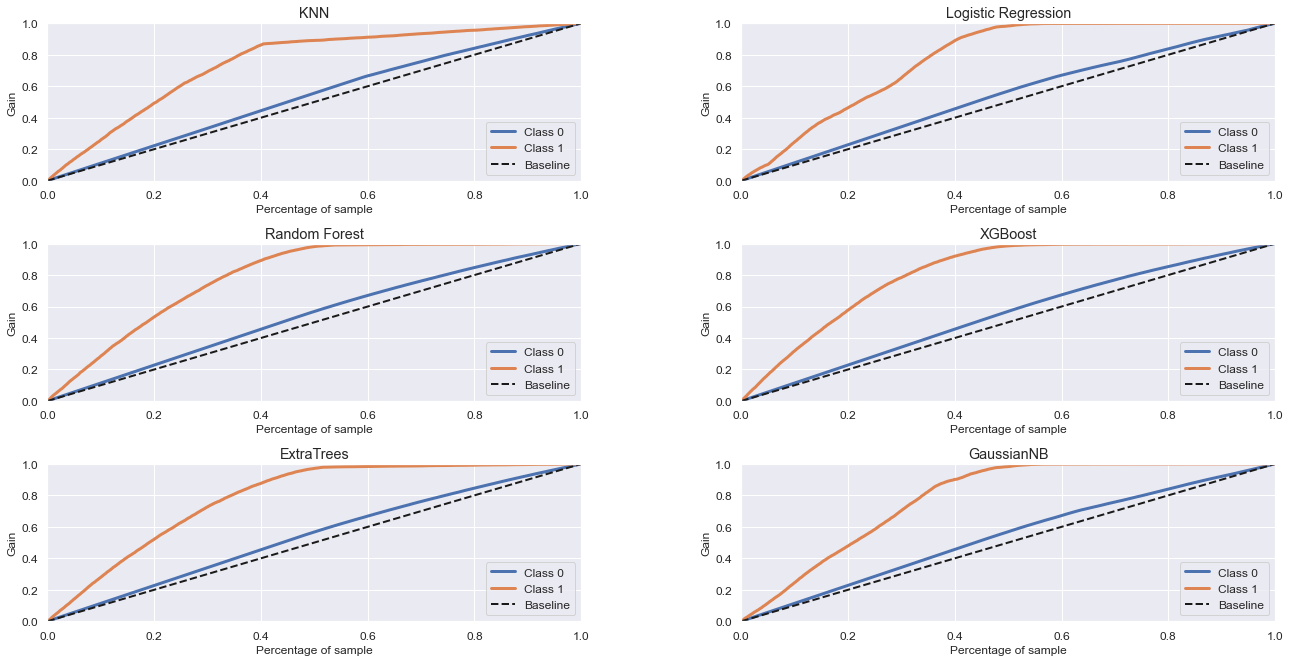

In [96]:
grid = plt.GridSpec(3, 2, wspace=0.3, hspace=0.4)
ax = plt.subplot(grid[0,0])
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn, ax = ax, title = 'KNN');

ax1 = plt.subplot(grid[0,1])
skplt.metrics.plot_cumulative_gain( y_val, yhat_logreg, ax = ax1, title = 'Logistic Regression');

ax2 = plt.subplot(grid[1,0])
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf, ax = ax2, title = 'Random Forest');

ax3 = plt.subplot(grid[1,1])
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb, ax = ax3, title = 'XGBoost');

ax4 = plt.subplot(grid[2,0])
skplt.metrics.plot_cumulative_gain( y_val, yhat_et, ax = ax4, title = 'ExtraTrees');

ax5 = plt.subplot(grid[2,1])
skplt.metrics.plot_cumulative_gain( y_val, yhat_nb, ax = ax5, title = 'GaussianNB');

### 7.7.2 Model Comparison - Cross Validation

In [97]:
k = 40000
k_folds = 5

#knn_cv_20k = cross_validation(k, k_folds, knn_model, x_training )
#logreg_cv_20k = cross_validation(k, k_folds, logreg_model, x_training )
#rf_cv_20k = cross_validation(k, k_folds, rf_model, x_training )
#xgb_cv_20k = cross_validation(k, k_folds, xgb_model, x_training )
#et_cv_20k = cross_validation(k, k_folds, et_model, x_training )
#nb_cv_20k = cross_validation(k, k_folds,  nb_model, x_training )

In [98]:
#dict_cv = {'knn': knn_cv_20k[ 'mean values' ] , 'logreg': logreg_cv_20k[ 'mean values' ], \
#        'rf': rf_cv_20k[ 'mean values' ], 'xgb': xgb_cv_20k[ 'mean values' ], \
#        'et': et_cv_20k[ 'mean values' ], 'nb': nb_cv_20k[ 'mean values' ],'max @ {}'.format(k): knn_cv_20k[ 'max values' ]}
#cv_comp = pd.DataFrame(dict_cv)

#cv_comp

# 8.0 STEP 08 - HYPERPARAMETER FINE TUNING

- Best models will be tuned and evaluated;
- Top performing model moves on to business performance analysis.

## 8.1 - Random Search

### 8.1.1 XGboost

In [99]:
param = { 'n_estimators': [ 1500, 1700, 2500, 3000, 2000, 3500], 
          'eta': [.01, 0.03, 0.05],
          'max_depth': [3, 5, 9],
          'subsample': [0.1, 0.5, 0.7],
          'min_child_weight': [3, 8, 15],
          'colsample_bytree': [0.3, 0.7, 0.9] }

MAX_EVAL = 8

In [100]:
#import random

#final_result_xgb = pd.DataFrame()

#for i in range( MAX_EVAL):
#    hp = {kf: random.sample(v, 1 )[0] for kf, v in param.items() }
#    print(hp)
    #modelo
#    xgb_model = xgb.XGBClassifier( objective = 'reg:squarederror', 
#                                 n_estimators = hp['n_estimators'], 
#                                 eta = hp['eta'], 
#                                 max_depth = hp['max_depth'], 
#                                 subsample = hp['subsample'],
#                                 min_child_weight = hp['min_child_weight'],
#                                 colsample_bytree = hp['colsample_bytree'] )

    # desempenho

#    xgb_result = cross_validation(20000, 5, xgb_model, x_training)
#   final_result_xgb = pd.concat([final_result_xgb, xgb_result])
#final_result_xgb

In [101]:
best_param_xgb = {'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'min_child_weight': 8, 'colsample_bytree': 0.9}

### 8.1.2 Random Forest

In [102]:
param = { 'n_estimators': [ 1500, 1700, 2500, 3000, 2000, 3500], 
          'max_features': ['auto', 'sqrt'],
          'max_depth': [15, 30, 45, 60, 75, 90, 105, 120],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'bootstrap': [True, False] }

MAX_EVAL = 8

In [103]:
#import random

#final_result_rf = pd.DataFrame()

#for i in range( MAX_EVAL):
#    hp = {kf: random.sample(v, 1 )[0] for kf, v in param.items() }
#    print(hp)
#    #modelo
#    rf_model = en.RandomForestClassifier( n_estimators = hp['n_estimators'], 
#                                 max_features = hp['max_features'], 
#                                 max_depth = hp['max_depth'], 
#                                 min_samples_split = hp['min_samples_split'],
#                                 min_samples_leaf = hp['min_samples_leaf'],
#                                 bootstrap = hp['bootstrap'] )

    # desempenho

#    rf_result = cross_validation(20000, 5, rf_model, x_training)
#    final_result_rf = pd.concat([final_result_rf, rf_result])
#final_result_rf

In [104]:
best_param_rf = {'n_estimators': 3500, 'max_features': 'sqrt', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True}

## 8.2 - Selecting Top Performing Model

### 8.2.1 Final comparison

In [105]:
#rf_model_tuned = en.RandomForestClassifier( n_estimators = best_param_rf['n_estimators'], 
#                                 max_features = best_param_rf['max_features'], 
#                                 max_depth = best_param_rf['max_depth'], 
#                                 min_samples_split = best_param_rf['min_samples_split'],
#                                 min_samples_leaf = best_param_rf['min_samples_leaf'],
#                                 bootstrap = best_param_rf['bootstrap'] )

In [106]:
#rf_result = cross_validation(20000, 5, rf_model_tuned, x_training)
#rf_result

In [107]:
#xgb_model_tuned = xgb.XGBClassifier( objective = 'reg:squarederror', 
#                                 n_estimators = best_param_xgb['n_estimators'], 
#                                 eta = best_param_xgb['eta'], 
#                                 max_depth = best_param_xgb['max_depth'], 
#                                 subsample = best_param_xgb['subsample'],
#                                 min_child_weight = best_param_xgb['min_child_weight'],
#                                 colsample_bytree = best_param_xgb['colsample_bytree'] )

In [108]:
#xgb_result = cross_validation(20000, 5, xgb_model_tuned, x_training)
#xgb_result

In [109]:
rf_mean_recall = 0.466184
xgb_mean_recall = 0.468282

Best performing model: **XGBoost**.

### 8.2.2 Saving model

In [110]:
#dumping model
#pickle.dump(xgb_model_tuned, open('model/xgbclassifier.pkl', 'wb' ) )


In [111]:
#Loading model
xgb_model_tuned = pickle.load( open('model/xgbclassifier.pkl', 'rb' ) )

# 9.0 STEP 09 - BUSINESS PERFORMANCE

In [112]:
# prediction
yhat_xgb_tuned = xgb_model_tuned.predict_proba( X_val_m )

In [113]:
mean_vehicle_annual_premium = 3000
interested_perc = y_val.value_counts()[1]/y_val.value_counts()[0]
interested_amount = round(interested_perc*test_sample_size)
print( 'There are approximately {} interested customers on the {} test sample'. format( interested_amount, test_sample_size ) )

There are approximately 18138 interested customers on the 127037 test sample


## 9.1 - What percentage of customers interested in purchasing auto insurance will we reach if we call 20000 customers?

In [114]:
#Percentage of test sample size

perc_20 = 20000/test_sample_size
print( 'Percentage of test sample size {:.2f}%'. format( perc_20*100 ) )

Percentage of test sample size 15.74%


In [115]:
#performance

#How many customers represent the same percentage?
k_prop_ml = round( 20000*len(y_val)/test_sample_size )

#calculating precision and recall
perf_xgb_tuned = metrics_top_k(yhat_xgb_tuned, y_val)

#checking recall on the predetermined amount of customers
rec_20 = perf_xgb_tuned.iloc[k_prop_ml -1, 5]
perf_xgb_tuned.iloc[ k_prop_ml -1 ]

index        53265.000000
response         1.000000
score            0.307208
ranking      12000.000000
precision        0.378167
recall           0.476531
Name: 11999, dtype: float64

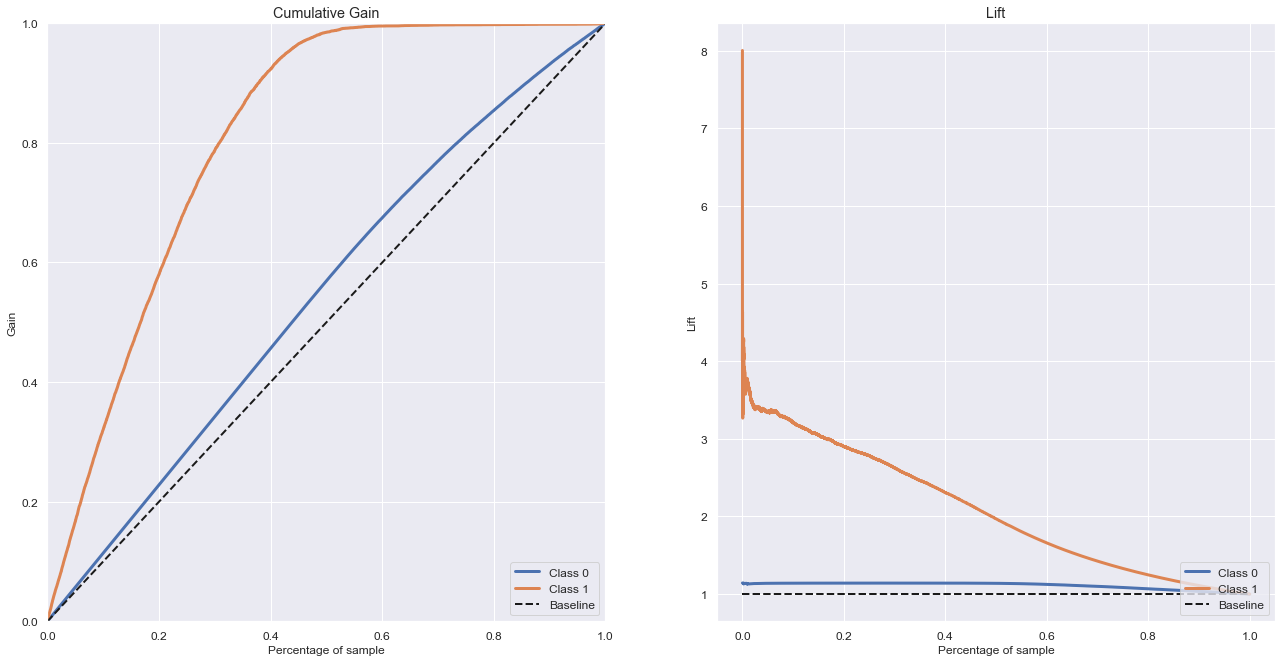

In [116]:
#plotting cumulative gain and lift curves
grid = plt.GridSpec(1, 2, wspace=0.2)
ax = plt.subplot(grid[0,0])
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb_tuned, ax = ax, title = 'Cumulative Gain');

ax1 = plt.subplot(grid[0,1])
skplt.metrics.plot_lift_curve( y_val, yhat_xgb_tuned, ax = ax1, title = 'Lift');

In [117]:
print( 'If the sales team makes 20000 calls they will reach ' + '\033[1m' + '{:.2f}% '.format(rec_20*100) + '\033[0m' + 'of interested costumers, which means '  + '\033[1m' + '{:.2f} '.format(rec_20/perc_20) + '\033[0m' +  'times what a random sample would reach.' )
print( 'Considering a mean annual premium value as ' + '\033[1m' + '$ {:.2f}'.format(mean_vehicle_annual_premium) + '\033[0m' + ', contacting 20000 customers from the ranked list would add up to '  + '\033[1m' + '$ {:0,.2f} '.format(mean_vehicle_annual_premium*rec_20*interested_amount)+ '\033[0m' )


If the sales team makes 20000 calls they will reach 47.65% of interested costumers, which means 3.03 times what a random sample would reach.
Considering a mean annual premium value as $ 3000.00, contacting 20000 customers from the ranked list would add up to $ 25,929,930.90 


## 9.2 What if or sales team increases its capacity to 40000 calls, what percentage of customers interested in purchasing auto insurance will we reach?

In [118]:
#Percentage of test sample size

perc_40 = 40000/test_sample_size
print( 'Percentage of test sample size: {:.2f}%'. format( perc_40*100 ) )

Percentage of test sample size: 31.49%


In [119]:
#performance

#How many customers represent the same percentage?
k_prop_ml = round( perc_40*len(y_val) )

#calculating precision and recall
perf_xgb_tuned = metrics_top_k(yhat_xgb_tuned, y_val)

#checking recall on the predetermined amount of customers
rec_40 = perf_xgb_tuned.iloc[k_prop_ml -1, 5]
perf_xgb_tuned.iloc[ k_prop_ml -1 ]

index        245021.000000
response          0.000000
score             0.208495
ranking       24000.000000
precision         0.321417
recall            0.810039
Name: 23999, dtype: float64

In [120]:
print( 'If the sales team makes 40000 calls they will reach ' + '\033[1m' + '{:.2f}% '.format(rec_40*100) + '\033[0m' + 'of interested costumers, which means '  + '\033[1m' + '{:.2f} '.format(rec_40/perc_40) + '\033[0m' +  'times what a random sample would reach.' )
print( 'Considering a mean annual premium value as ' + '\033[1m' + '$ {:.2f}'.format(mean_vehicle_annual_premium) + '\033[0m' + ', contacting 40000 customers from the ranked list would add up to '  + '\033[1m' + '$ {:0,.2f} '.format(mean_vehicle_annual_premium*rec_40*interested_amount)+ '\033[0m' )


If the sales team makes 40000 calls they will reach 81.00% of interested costumers, which means 2.57 times what a random sample would reach.
Considering a mean annual premium value as $ 3000.00, contacting 40000 customers from the ranked list would add up to $ 44,077,454.16 


## 9.3 How many calls would the sales team need to make to reach 80% of interested customers in purchasing auto insurance?

In [121]:
# identifying where recall reaches 80%
aux = perf_xgb_tuned[ perf_xgb_tuned[ 'recall'] >= .8 ]
id_80 = aux.index[0]

# Percentage of validation dataset where recall reaches 80% 
eighty_perc_val = id_80/perf_xgb_tuned.shape[0]
print( 'Percentage of test sample size: {:.2f}%'. format( eighty_perc_val*100 ) )

Percentage of test sample size: 30.80%


In [122]:
# calculating the same percentage of test sample
eighty_perc = round(eighty_perc_val*test_sample_size)
print( 'Number of calls: {}'. format( eighty_perc ) )

Number of calls: 39130


In [123]:
print( 'To reach 80% of interested costumers the sales team would need to make ' + '\033[1m' + '{:.0f} '.format(eighty_perc) + '\033[0m' + 'calls.' )

To reach 80% of interested costumers the sales team would need to make 39130 calls.


# 10.0 STEP 10 - MODEL DEPLOYMENT INTO PRODUCTION

## 10.1 Insurance Class

In [124]:
import pickle
import pandas as pd
import numpy as np

class Insurance( object ):
    def __init__( self ):
        self.annual_premium_scaler   = pickle.load( open( 'parameters/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler              = pickle.load( open( 'parameters/age_scaler.pkl', 'rb' ) )
        self.vintage_scaler          = pickle.load( open( 'parameters/vintage_scaler.pkl', 'rb' ) )
     
       
    def data_preparation( self, df5 ):

        df3 = df5.copy()

        #column renaming

        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 
                    'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage']

        df3.columns = cols_new

        #standardization
        #annual premium
        df3['annual_premium'] = self.annual_premium_scaler.transform( df3[['annual_premium']].values )
        
        
        #reescaling
        #age
        df3['age'] = self.age_scaler.transform( df3[['age']].values )
        
        #vintage
        df3['vintage'] = self.vintage_scaler.transform( df3[['vintage']].values )
        
        
        #encoding
        #region_code - frequency encoding
        fe_region_code = df3.groupby('region_code').size()/len( df3 )
        df3.loc[:, 'region_code'] = df3['region_code'].map( fe_region_code)

        #policy_sales_channel - frequency encoding
        fe_region_code = df3.groupby('policy_sales_channel').size()/len( df3 )
        df3.loc[:, 'policy_sales_channel'] = df3['policy_sales_channel'].map( fe_region_code)

        #vehicle_age
        df3 = pd.get_dummies( df3, prefix = ['vehicle_age'], columns = ['vehicle_age'] )

        #gender
        df3['gender'] = df3['gender'].apply( lambda x: 1 if x == 'Male' else 0)

        #vehicle_damage
        df3['vehicle_damage'] = df3['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

        cols_selected_importance = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']
        
        return df3[ cols_selected_importance ]
        

    
    def get_prediction( self, model, original_data, test_data):
        
        #prediction
        pred = model.predict_proba( test_data )
        
        #merging prediction into original dataset
        original_data['score'] = pred[:,1].tolist()
        original_data = original_data.sort_values(by = 'score', ascending = False)
        original_data = original_data.reset_index()
        
        return original_data.to_json( orient = 'records', date_format = 'iso')
        

## 10.2 API Handler

In [125]:
import os
import pickle

import pandas     as pd

from flask import Flask, request, Response

from insurance.Insurance import Insurance

#loading model
model = pickle.load( open( 'modelo/xgbclassifier.pkl', 'rb' ) )


#API intialization
app = Flask( __name__ )

@app.route( '/insurance/predict', methods = ['POST'] )

def insurance_predict():
	test_json = request.get_json()
    
	if test_json: # there is data
		if isinstance( test_json, dict ): #single example
			test_raw = pd.DataFrame( test_json, index = [0] )
            
		else:  #multiple example      
			test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
            
		# instantiate insurance class
		pipeline = Insurance()
        
		#data preparation
		df3 = pipeline.data_preparation( test_raw )
        
		#prediction
		df_response = pipeline.get_prediction( model, test_raw, df3 )
        
		return df_response
            
	else: # no data
		return Response( '{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
	port = os.environ.get( 'PORT', 5000)
	app.run(host = '0.0.0.0', port = port )

ModuleNotFoundError: No module named 'insurance'

## 10.3 API Tester

In [ ]:
import json
import requests

In [ ]:
#carregar dataset de teste
df_test = pd.read_csv( 'data/test.csv' )

In [ ]:
#X = df_raw.drop('response', axis = 1)
#y = df_raw['response']
#X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
df_test.head()

In [ ]:
data = json.dumps( df_test.to_dict( orient = 'records' ) )

In [ ]:
#url = 'http://localhost:5000/insurance/predict'
url = 'https://fresmini-insurance.herokuapp.com/insurance/predict'

header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers = header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
score_df = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [ ]:
score_df.head()